In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [3]:
sns.set(rc={'figure.figsize':(24, 13.5)}, font_scale = 2.7)

In [14]:
recovery = pd.read_csv('recovery-data/recovery-data.csv', index_col = 'Time')
telemetry = pd.read_csv('maiden_launch_combined_telemetry.csv', index_col='Time [s]')
combined = recovery.drop_duplicates().sort_index().reset_index()

t_ig = 2280.35
t0 = t_ig-2 # time of start of plot [s]
duration = 34  # flight duration [s]
g = -9.81 # correct for gravity

combined['Time [s]'] = (combined['Time'])/1000 - t_ig
combined['Acceleration 1 [g]'] = (combined['Ay_IMU1'] / g)
combined['Acceleration 2 [g]'] = (combined['Ay_IMU2'] / g)
combined['Temperature [°C]'] = combined['T_SHT']
combined['Humidity [%]'] = combined['H_SHT']
#combined['Battery [V]'] = combined['battery_battery']/1000
combined['Pressure 1 [kPa]'] = combined['P_BARO1']/1000
combined['Pressure 2 [kPa]'] = combined['P_BARO2']/1000

gyro_labels = ['Gx_IMU1','Gy_IMU1','Gz_IMU1','Gx_IMU2','Gy_IMU2','Gz_IMU2']
acc_labels = ['Ax_IMU1','Ay_IMU1','Az_IMU1','Ax_IMU2','Ay_IMU2','Az_IMU2']

for label in gyro_labels:
    combined[label] /= 2
#convert to gs
fmt_acc = lambda x: x / 1024
#convert to degrees per second
fmt_gyro = lambda x: x / 16.4
dim3 = lambda x : [x + '_' + s for s in ['x', 'y', 'z']]

telemetry[dim3('Acceleration')] = telemetry[dim3('sb_data_acc')].apply(pd.to_numeric).apply(fmt_acc)
telemetry[dim3('Gyro')] = telemetry[dim3('sb_data_gyro')].apply(pd.to_numeric).apply(fmt_gyro)

telemetry.index += -1.55
#
combined = combined[combined['Time [s]']>-2].reset_index()
telemetry = telemetry[telemetry.index>-2].reset_index()

# Some options
show_telemetry = True     # whether to display telemetry data points
show_flight_events = True # whether to display ignition, burnout, apogee
show_actuation = True     # whether to display airbrake actuation areas

t_ignition = 0 # time of ignition [s]
t_burnout = 3.85  # time of burnout [s]
t_cruise = 4.05  # time of begin of cruise flight [s]
t_apogee = combined['Time [s]'][pd.Series.argmin(combined['Pressure 1 [kPa]'])]


def plot_events(plt):
    if show_flight_events:
        plt.axvline(x=t_ignition, color='k')
        plt.axvline(x=t_burnout, color='k')
        plt.axvline(x=t_apogee, color='k')
    if show_actuation:
        plt.axvspan(5.4, 5.8, color='b', alpha=0.2)
        plt.axvspan(7.15, 8.2, color='b', alpha=0.2)
        plt.axvspan(9.55, 14.45, color='b', alpha=0.2)
        


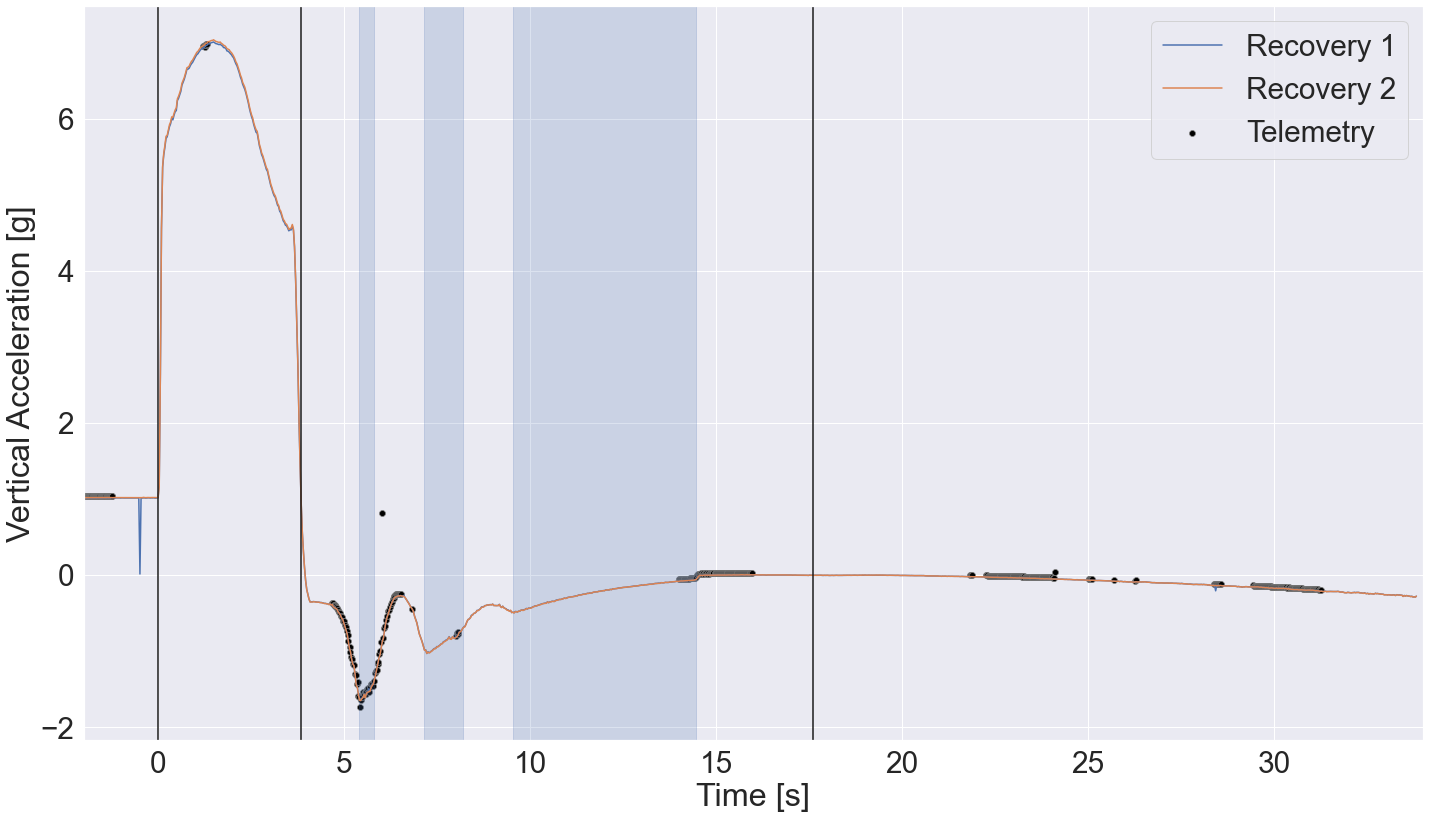

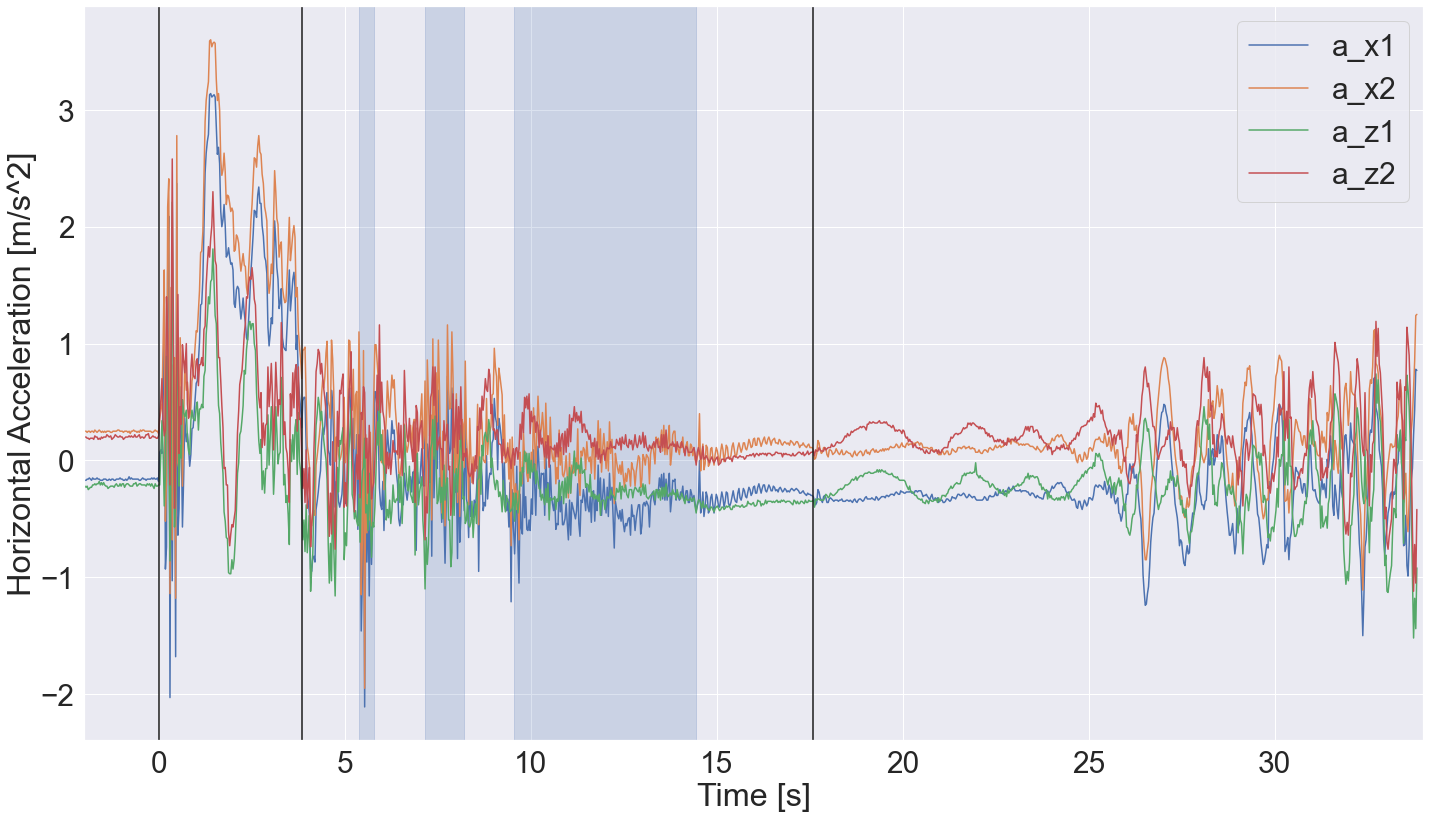

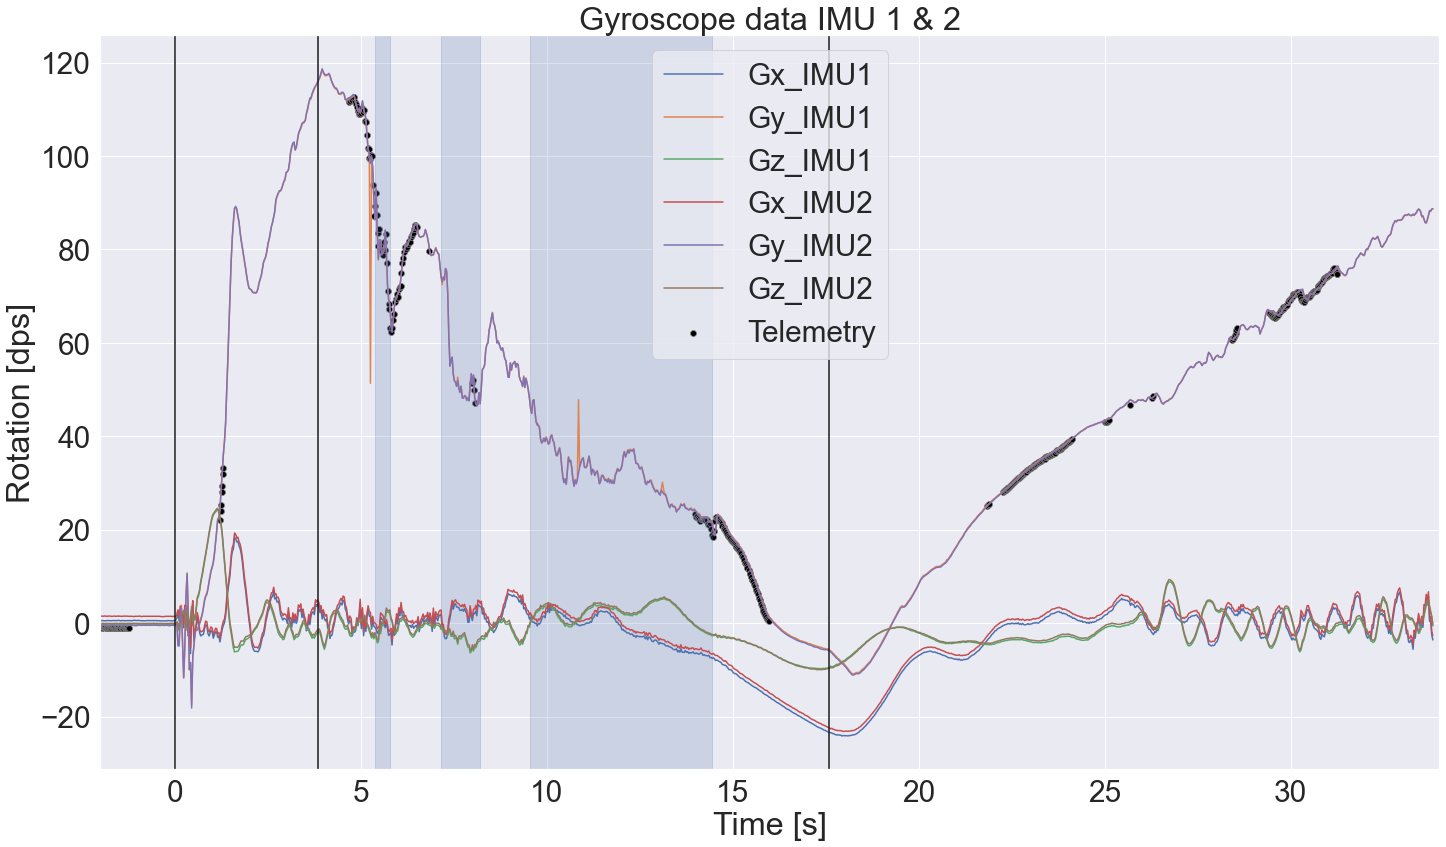

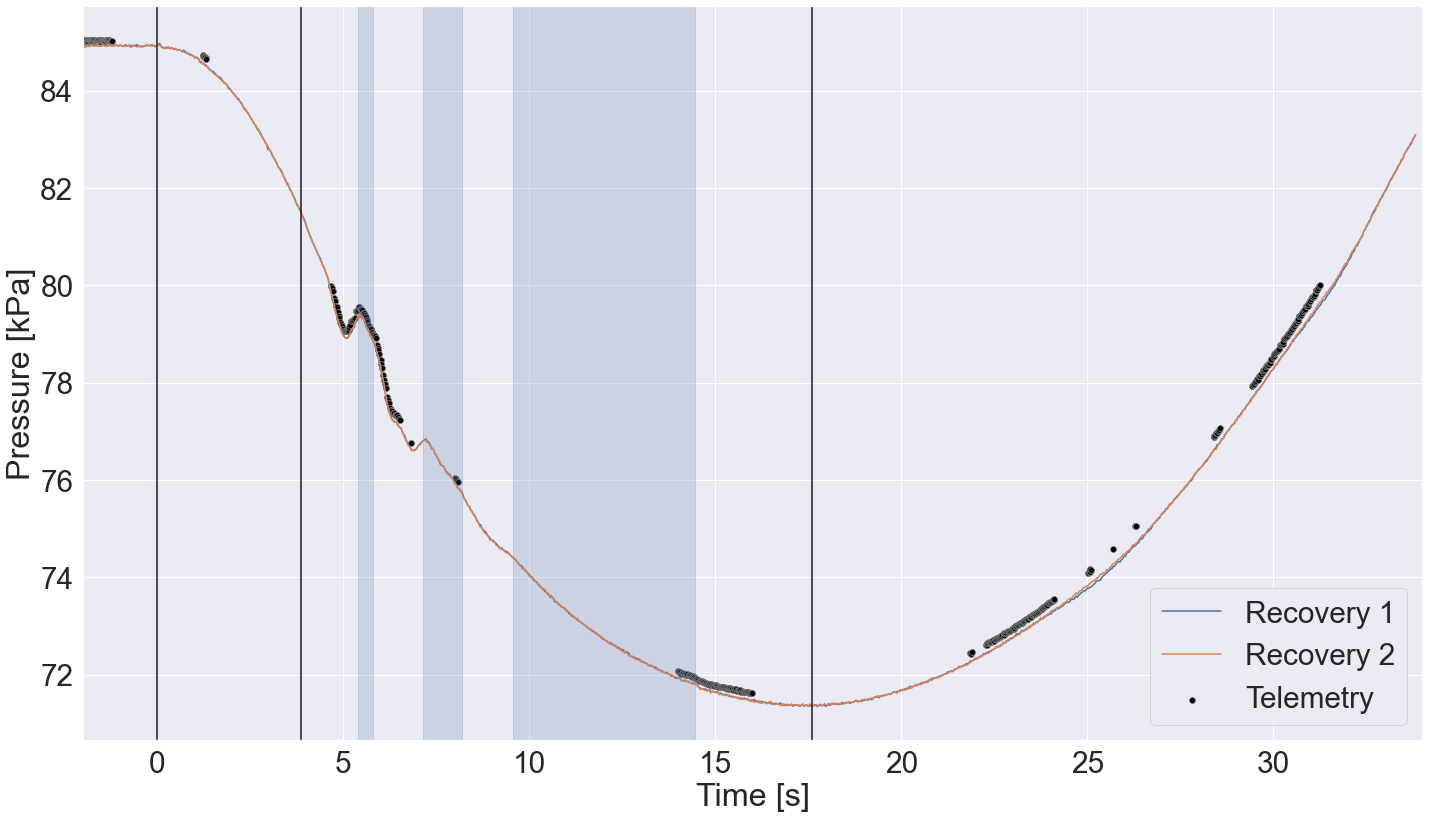

In [15]:
# ACC ROLL AXIS PLOT
ax = sns.lineplot(data = combined, x = 'Time [s]', y = 'Acceleration 1 [g]', label="Recovery 1")
ax = sns.lineplot(data = combined, x = 'Time [s]', y = 'Acceleration 2 [g]', label="Recovery 2")

if show_telemetry:
    ax = sns.scatterplot(data = telemetry, x = 'Time [s]', y = 'Acceleration_z', color = 'black', edgecolor='gray', label='Telemetry')

plot_events(plt)

ax.set_ylabel('Vertical Acceleration [g]')
ax.set_xlabel('Time [s]')
ax.set_xlim(-2, duration)

plt.show()

# ACC HORIZONTAL PLOT
ax = sns.lineplot(data = combined, x = 'Time [s]', y = 'Ax_IMU1', label='a_x1')
ax = sns.lineplot(data = combined, x = 'Time [s]', y = 'Ax_IMU2', label='a_x2')
ax = sns.lineplot(data = combined, x = 'Time [s]', y = 'Az_IMU1', label='a_z1')
ax = sns.lineplot(data = combined, x = 'Time [s]', y = 'Az_IMU2', label='a_z2')
plot_events(plt)

ax.set_ylabel('Horizontal Acceleration [m/s^2]')
ax.set_xlabel('Time [s]')
ax.set_xlim(-2, duration)

plt.legend(loc='upper right')
plt.show()


# GYRO PLOT
for label in gyro_labels:
    ax = sns.lineplot(data = combined, x = 'Time [s]', y = label, label=label)

if show_telemetry:
    ax = sns.scatterplot(data = telemetry.reset_index(), x = 'Time [s]', y = 'Gyro_z', color = 'black', edgecolor='gray', label='Telemetry')

plot_events(plt)
ax.set_title(f'Gyroscope data IMU 1 & 2')
ax.set_ylabel('Rotation [dps]')
ax.set_xlabel('Time [s]')
ax.set_xlim(-2, duration)
plt.legend(loc='upper center')
plt.show()

#plt = sns.scatterplot(data = combined.reset_index(), x = 'Time [s]', y = 'Pressure [kPa]', color = 'black', edgecolor='gray')
ax = sns.lineplot(data = combined.reset_index(), x = 'Time [s]', y = 'Pressure 1 [kPa]', label="Recovery 1")
ax = sns.lineplot(data = combined.reset_index(), x = 'Time [s]', y = 'Pressure 2 [kPa]', label="Recovery 2")
plot_events(plt)

if show_telemetry:
    ax = sns.scatterplot(data = telemetry.reset_index(), x = 'Time [s]', y = 'Pressure [kPa]', color = 'black', edgecolor='gray', label='Telemetry')

ax.set_ylabel('Pressure [kPa]')
ax.set_xlabel('Time [s]')
ax.set_xlim(-2, duration)
plt.show()



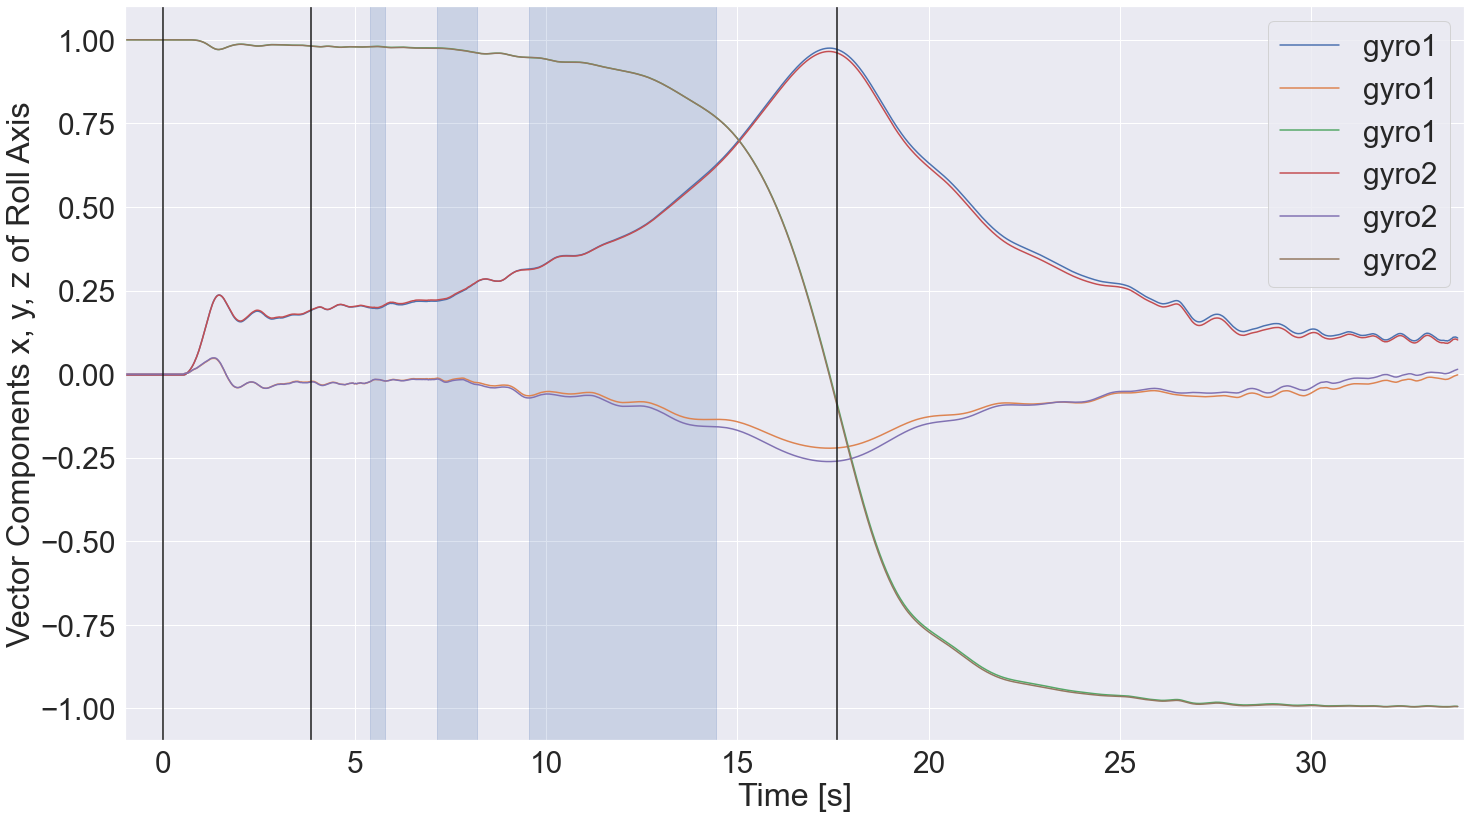

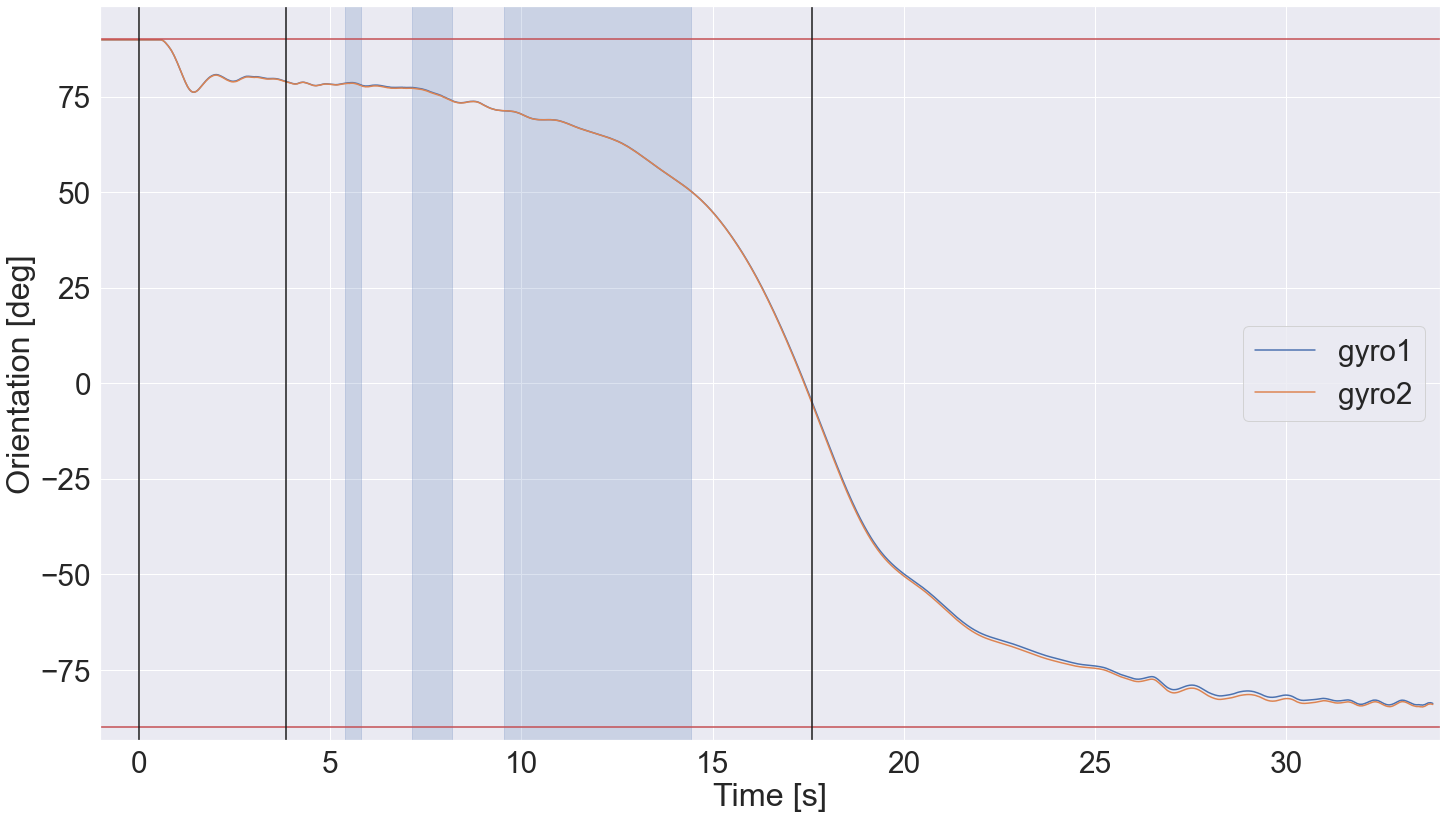

In [16]:
from scipy.spatial.transform import Rotation as R

def compensate_gyro_offset(data, gyro_labels):
    for label in gyro_labels:
        data[label] = data[label] - data[label][combined["Time [s]"]<-0.2].mean()
    return data

def compensate_acc_offset(data, acc_labels):
    for label in acc_labels:
        if label[1]=="y":
            data[label] = data[label] - data[label][combined["Time [s]"]<-0.7].mean() - 9.81
        else:
            data[label] = data[label] - data[label][combined["Time [s]"]<-0.7].mean()
    return data

def get_rotations_from_gyro(t, gyro_x, gyro_y, gyro_z):
    dt_array = np.diff(np.array(t),prepend=0)
    R_tot = R.from_rotvec(np.array([0, 0, 0]))
    W_gyro = np.array([gyro_x, gyro_y, gyro_z]) / 180*np.pi * dt_array
    W_gyro = np.where(np.array([t]).T<0.55, np.array([0, 0, 0]), W_gyro.T).T
    rot_ang_roll = np.cumsum(gyro_z* dt_array) / 180*np.pi 
    
    R_array = []

    for i in range(len(t)):      
        dR_array_i =  R.from_rotvec(W_gyro.T[i])        
        R_tot = dR_array_i * R_tot 
        # R_derotation is needed to get correct x and y components of rockets roll axis orientation
        R_derotation = R.from_euler("z", -rot_ang_roll[i])
        R_array.append(R_derotation * R_tot)
    
    return R_array

def get_orientations_from_rots(R_array):
    RA0 = np.array([0,0,1])
    PA0 = np.array([0,1,0])
    YA0 = np.array([1,0,0])
    
    RA_array = []
    PA_array = []
    YA_array = []
    
    for i in R_array:
        RA = i.apply(RA0)
        PA = i.apply(PA0)
        YA = i.apply(YA0)
        RA_array.append(RA)
        PA_array.append(PA)
        YA_array.append(YA)

    return RA_array, PA_array, YA_array


def derot_array(array, dir_angle, LR_angle=0):
    R_dir = R.from_euler("z", dir_angle, degrees=True)
    R_LR = R.from_euler("y", LR_angle, degrees=True)
    array_derot = R_LR.apply(R_dir.apply(array))
    
    return array_derot

# altitude and hor distance of lr and td (in m)
alt_LR = 1563
pos_LR = 0
alt_TD = 1730
pos_TD = 594

# relative orientaion of rocket (IMU) wrt to horizontal flight path
dir_angle = 5 # degrees
LR_angle = -0.15 # degrees

combined = compensate_gyro_offset(combined, gyro_labels)
combined = compensate_acc_offset(combined, acc_labels)

dR_array1 = get_rotations_from_gyro(combined["Time [s]"],combined["Gx_IMU1"],combined["Gz_IMU1"],combined["Gy_IMU1"])
dR_array2 = get_rotations_from_gyro(combined["Time [s]"],combined["Gx_IMU2"],combined["Gz_IMU2"],combined["Gy_IMU2"])

RA_array1, PA_array1, YA_array1  = get_orientations_from_rots(dR_array1)
RA_array2, PA_array2, YA_array2  = get_orientations_from_rots(dR_array2)

RA_array1  = derot_array(RA_array1, dir_angle=dir_angle, LR_angle=LR_angle)
RA_array2  = derot_array(RA_array2, dir_angle=dir_angle, LR_angle=LR_angle)
PA_array1  = derot_array(PA_array1, dir_angle=dir_angle, LR_angle=LR_angle)
PA_array2  = derot_array(PA_array2, dir_angle=dir_angle, LR_angle=LR_angle)
YA_array1  = derot_array(YA_array1, dir_angle=dir_angle, LR_angle=LR_angle)
YA_array2  = derot_array(YA_array2, dir_angle=dir_angle, LR_angle=LR_angle)


plt.plot(combined["Time [s]"], RA_array1, label="gyro1")
plt.plot(combined["Time [s]"], RA_array2, label="gyro2")
plt.xlim(-1, duration)
plt.xlabel("Time [s]")
plt.ylabel("Vector Components x, y, z of Roll Axis")
plt.legend()
plot_events(plt)
plt.show()


def plot_RA_angle(t_array, RA_array, label):
    plt.plot(t_array,90-180/np.pi*np.arccos(RA_array[:,2]), label=label)
    
plot_RA_angle(combined["Time [s]"], RA_array1, "gyro1")
plot_RA_angle(combined["Time [s]"], RA_array2, "gyro2")
plt.xlabel("Time [s]")
plt.ylabel("Orientation [deg]")
plt.axhline(90, color="r")
plt.axhline(-90, color="r")
plt.legend()
plt.xlim(-1, duration)
plot_events(plt)
plt.show()



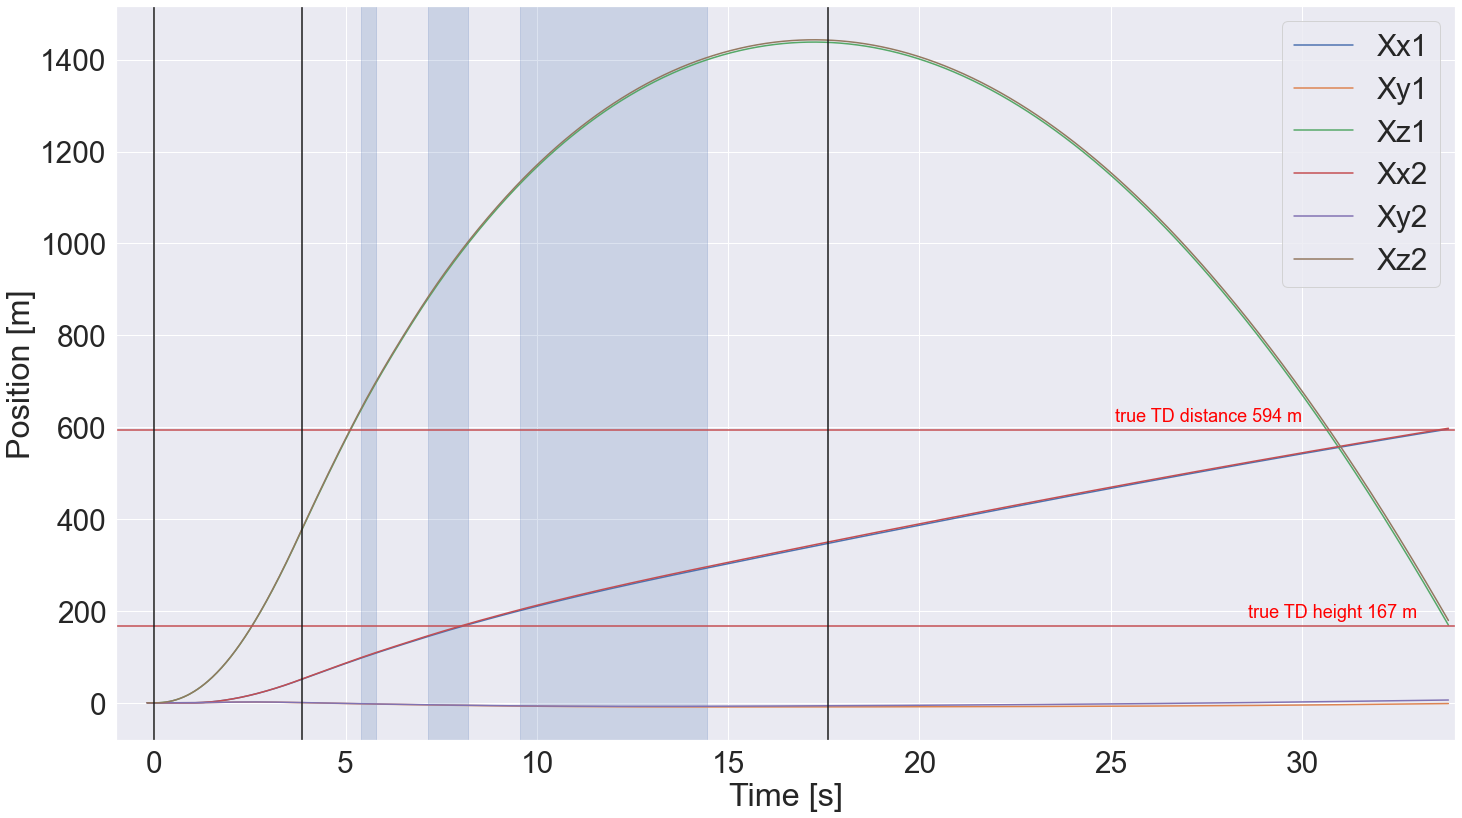

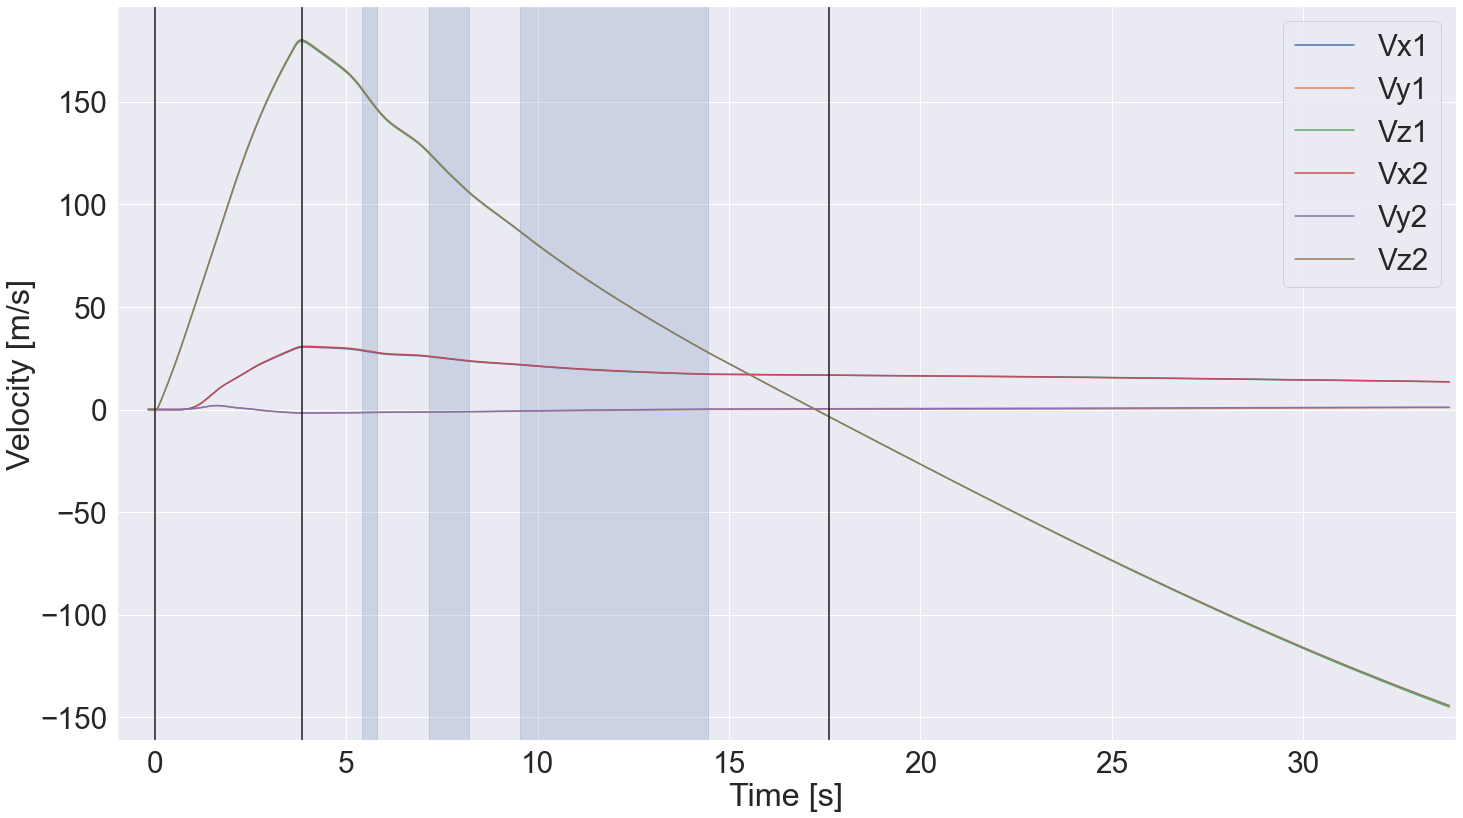

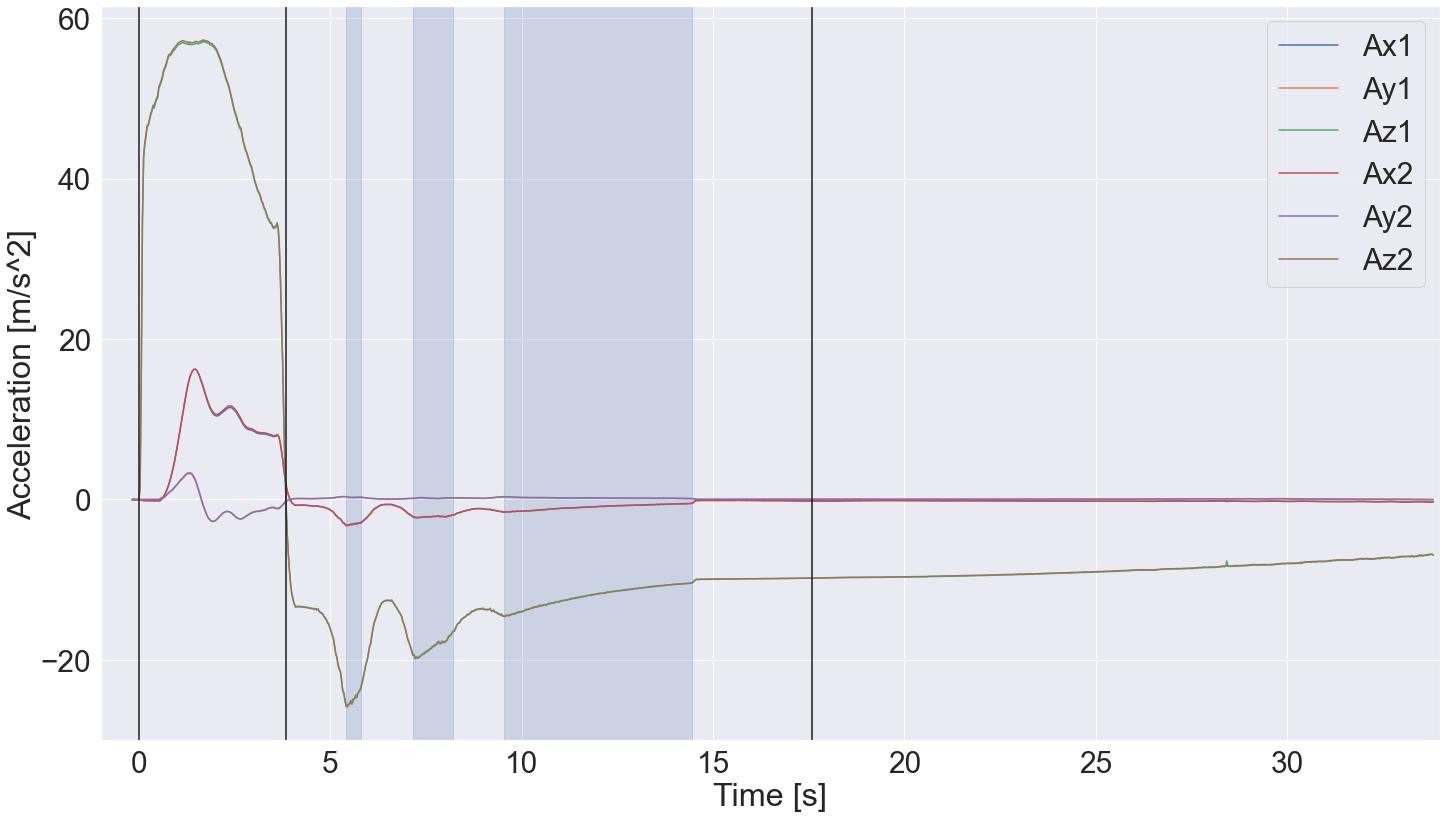

In [17]:
def get_vel_and_pos(t_array, YA_array, PA_array, RA_array, A_IMU1):
    cond_launch = t_array>-0.2
    t_array = np.array(t_array[cond_launch])
    RA_array = np.array(RA_array[cond_launch])
    A_IMU1 = np.array(A_IMU1[cond_launch])

    n = len(t_array)
    X = np.array([0,0,0]).astype(float)
    V = np.array([0,0,0]).astype(float)
    A = np.array([0,0,0]).astype(float)
    X_array = np.zeros((n,3))
    V_array = np.zeros((n,3))
    A_array = np.zeros((n,3))
    
    dt_array = np.diff(np.array(t_array),prepend=0)
    
    g = 9.81
    A_g = np.array([0,0,-g])
    
    for i in range(len(t_array)):
        if t_array[i]<0.7:
            A = A_IMU1[i,2] * RA_array[i] + A_g #+ A_IMU1[i,0] * YA_array[i] + A_IMU1[i,1] * PA_array[i]
        else:
            A = A_IMU1[i,2] * RA_array[i] + A_g #+ A_IMU1[i,0] * YA_array[i] + A_IMU1[i,1] * PA_array[i]

        V += A * dt_array[i]
        X += V * dt_array[i]
        
        A_array[i] = A
        V_array[i] = V
        X_array[i] = X
        
    return t_array, X_array, V_array, A_array

A_IMU1 = np.array([-combined["Ax_IMU1"],-combined["Az_IMU1"],-combined["Ay_IMU1"]]).T
A_IMU2 = np.array([-combined["Ax_IMU2"],-combined["Az_IMU2"],-combined["Ay_IMU2"]]).T


t_array, X_array1, V_array1, A_array1 = get_vel_and_pos(combined["Time [s]"],
                                                      YA_array1,
                                                      PA_array1,
                                                      RA_array1,
                                                      A_IMU1)
t_array, X_array2, V_array2, A_array2 = get_vel_and_pos(combined["Time [s]"],
                                                      YA_array2,
                                                      PA_array2,
                                                      RA_array2,
                                                      A_IMU2)

def plot_3d_array(t_array, array, vector_type):
    comps = ["x","y","z"]
    for i in range(array.shape[1]):
        plt.plot(t_array, array[:,i], label=vector_type[0]+comps[i]+vector_type[-1])
        plt.xlabel("Time [s]")
        

plot_3d_array(t_array, X_array1, vector_type="X1")
plot_3d_array(t_array, X_array2, vector_type="X2")
plt.ylabel("Position [m]")
plt.axhline(alt_TD-alt_LR, color="r")
plt.axhline(pos_TD-pos_LR, color="r")
plt.text(30, pos_TD-pos_LR+20, f"true TD distance {pos_TD-pos_LR:.0f} m", fontsize=18, ha="right", color="red")
plt.text(33, alt_TD-alt_LR+20, f"true TD height {alt_TD-alt_LR:.0f} m", fontsize=18, ha="right", color="red")
plt.legend()
plot_events(plt)
plt.xlim(-1, duration)
plt.show()

plot_3d_array(t_array, V_array1, vector_type="V1")
plot_3d_array(t_array, V_array2, vector_type="V2")
plt.ylabel("Velocity [m/s]")
plt.legend()
plot_events(plt)
plt.xlim(-1, duration)
plt.show()

plot_3d_array(t_array, A_array1, vector_type="A1")
plot_3d_array(t_array, A_array2, vector_type="A2")
plt.legend()
plt.ylabel("Acceleration [m/s^2]")
plot_events(plt)
plt.xlim(-1, duration)
plt.show()


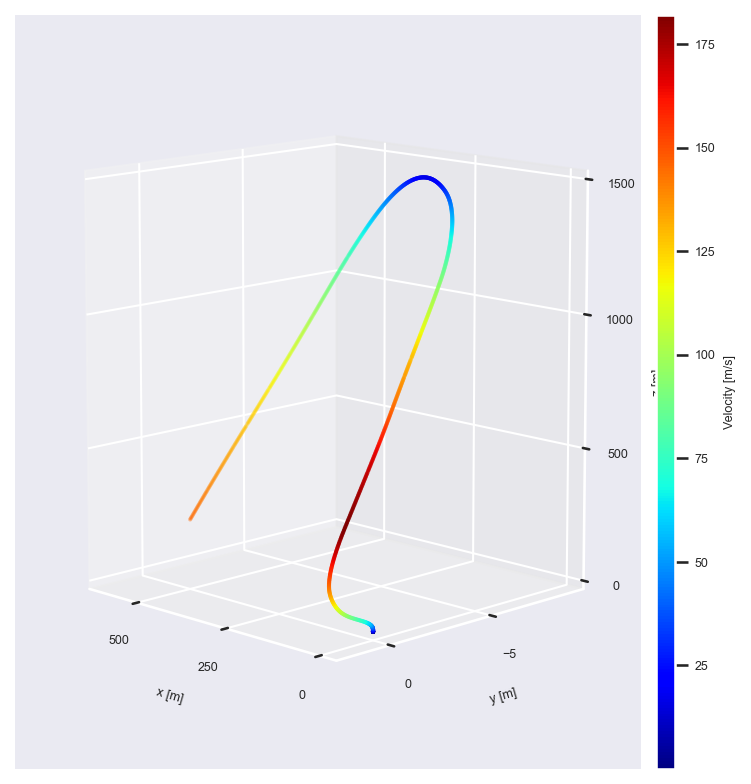

In [18]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6), dpi=150)
ax = fig.add_subplot(1,1,1,projection='3d')
ax.view_init(10, 135)

x, y, z = X_array1.T  # transpose and unpack 
V_abs1 = np.sqrt(V_array1[:,0]**2+V_array1[:,1]**2+V_array1[:,2]**2)
V_abs2 = np.sqrt(V_array2[:,0]**2+V_array2[:,1]**2+V_array2[:,2]**2)

p = ax.scatter(x,y,z, c=V_abs1, cmap="jet", s=1)
fontsize=6
 
#cmap = plt.cm.viridis()
cbar = fig.colorbar(p, pad=0.02, aspect=40)
cbar.set_label("Velocity [m/s]", size=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

ax.set_xlabel("x [m]", size=fontsize)
ax.set_ylabel("y [m]", size=fontsize)
ax.set_zlabel("z [m]", size=fontsize)

#ax.set_xlim(0,1500)
#ax.set_ylim(0,1500)
ax.set_zlim(0,1500)

for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(fontsize)
for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(fontsize)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(fontsize)

plt.tight_layout()
plt.show()

Cd_tot1: 1.7589663521280152 , Cd_tot2: 1.7762278784224081 , Mean: 1.7675971152752117
Cd_ro1: 0.34888498017433434 , Cd_ro2: 0.3604078287715637 , Mean: 0.35464640447294904


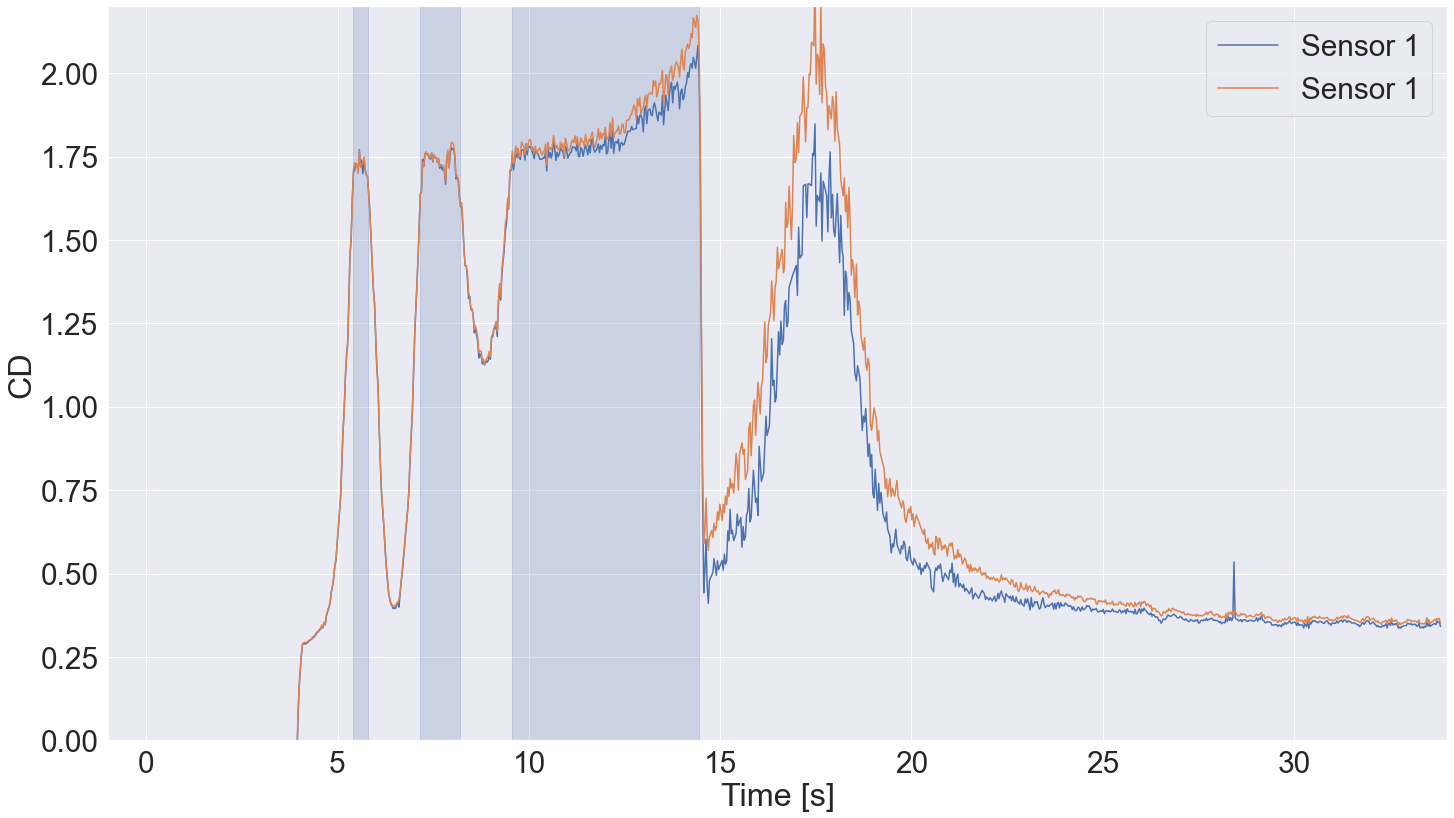

In [23]:
Temp_grad = 0.0065
R_star = 8.3144598
M = 0.0289644
R_const = R_star / M
n = (-g / (Temp_grad * R_const)) - 1
Temp_0 = 273.15
Temp_g = 20
Temp_g = Temp_0 + Temp_g
rho_sea = 1.225
P_sea = 1.01325e5
Temp_sea = 288.15
Pressure_g = 84900
gamma = 1.4

m_empt = 31.5      # kg
A_ref_rocket = np.pi * (0.179/2)**2

def compute_density(alt):
    actual_temp = Temp(alt)
    rho_g = rho_sea * ((Pressure_g / P_sea) * (Temp_sea / Temp_g))
    rho = rho_g * (actual_temp / Temp_g) ** n
    return rho
def Temp(alt):
    T = Temp_g - alt * Temp_grad
    return T


cond_launch = combined["Time [s]"]>-0.2

V_abs1 = np.sqrt(V_array1[:,0]**2+V_array1[:,1]**2+V_array1[:,2]**2)
V_abs2 = np.sqrt(V_array2[:,0]**2+V_array2[:,1]**2+V_array2[:,2]**2)
rho1 = compute_density(X_array1[:,2])
rho2 = compute_density(X_array2[:,2])
F1 = combined['Ay_IMU1'][cond_launch] * m_empt
F2 = combined['Ay_IMU2'][cond_launch] * m_empt
Cd1 = 2*F1 / (V_abs1**2*A_ref_rocket*rho1)
Cd2 = 2*F2 / (V_abs2**2*A_ref_rocket*rho2)


t1=10
t2=11
cond_cd_tot = (t_array>t1)&(t_array<t2)
Cd_tot1 = Cd1[cond_cd_tot].mean()
Cd_tot2 = Cd2[cond_cd_tot].mean()
Cd_tot_mean = 0.5*(Cd_tot1+Cd_tot2)
print("Cd_tot1:", Cd_tot1,", Cd_tot2:", Cd_tot2, ", Mean:", Cd_tot_mean)
#plt.axvline(t1, color="black")
#plt.axvline(t2, color="black")

t3=30
t4=33.5
cond_cd_ro = (t_array>t3)&(t_array<t4)
Cd_ro1 = Cd1[cond_cd_ro].mean()
Cd_ro2 = Cd2[cond_cd_ro].mean()
Cd_ro_mean = 0.5*(Cd_ro1+Cd_ro2)
print("Cd_ro1:", Cd_ro1,", Cd_ro2:", Cd_ro2, ", Mean:", Cd_ro_mean)


plt.plot(combined["Time [s]"][cond_launch], Cd1, label="Sensor 1")
plt.plot(combined["Time [s]"][cond_launch], Cd2, label="Sensor 1")
#plt.axvline(t3, color="black")
#plt.axvline(t4, color="black")
#plt.axhline(Cd_tot_mean, color="red")

plt.ylim(0,2.2)
plt.xlabel("Time [s]")
plt.ylabel("CD")

show_flight_events=False
plot_events(plt)
show_flight_events=True
plt.xlim(-1, duration)
plt.legend()



thrust measured mean: 7678.5
thrust thrustcurve:7661.4
thrust datasheet 7802

Motor efficiency Thrustcurve: 1.002
Motor efficiency Datasheet: 0.984


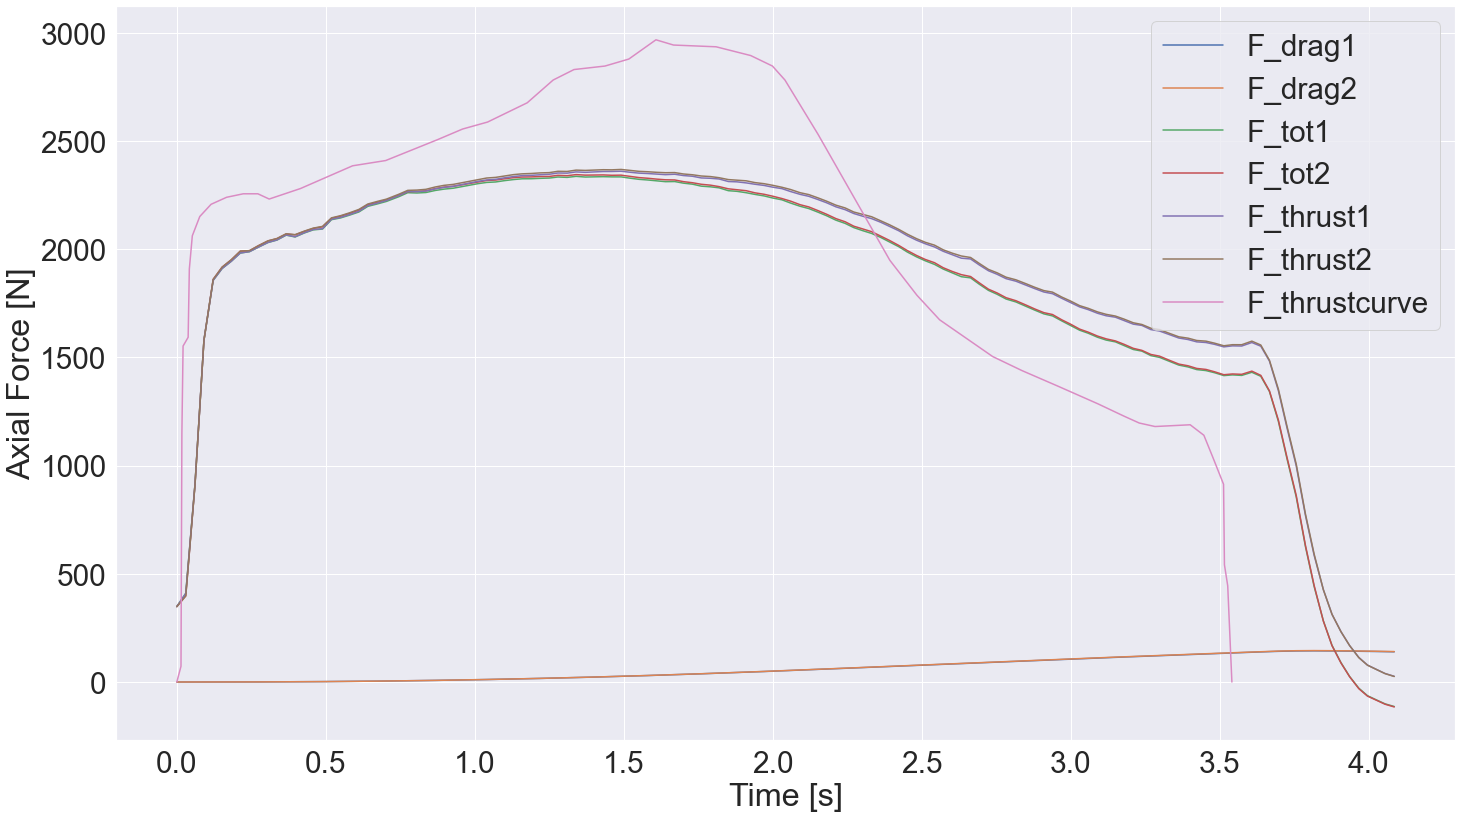

In [24]:
# Motor efficiency
cond_thrust = (combined["Time [s]"][cond_launch]>=0)&(combined["Time [s]"][cond_launch] < 4.1)
t_arr_thrust = combined["Time [s]"][cond_launch][cond_thrust]

F_D1 = 0.5* Cd_ro_mean * A_ref_rocket * rho1[cond_thrust] * V_abs1[cond_thrust]**2
F_D2 = 0.5* Cd_ro_mean * A_ref_rocket * rho2[cond_thrust] * V_abs2[cond_thrust]**2

a1 = A_IMU1[cond_launch][cond_thrust][:,2] #- RA_array1[cond_launch][cond_thrust][:,2] * g
a2 = A_IMU2[cond_launch][cond_thrust][:,2] #- RA_array2[cond_launch][cond_thrust][:,2] * g

m_t = 35.5 - 4. * t_arr_thrust/4
m_t = np.maximum(31.5, m_t)

F1 = a1 * m_t
F2 = a2 * m_t

Fthrust1 = F1 + F_D1
Fthrust2 = F2 + F_D2

thrust_tot1 = sp.integrate.simps(Fthrust1, t_arr_thrust)
thrust_tot2 = sp.integrate.simps(Fthrust2, t_arr_thrust)
thrust_tot = (thrust_tot1+thrust_tot2)/2

thrustcurve_t = np.array([0,0.014, 0.017,0.021,0.038,0.042,0.052,0.077,0.115,0.167,0.223,0.272,0.31,0.415,0.59,0.701,
                        0.876,0.959,1.043,1.176,1.263,1.333,1.437,1.517,1.608,1.667,1.81,1.926,1.999,2.041,2.152,2.393,
                        2.484,2.56,2.738,2.836,2.958,3.091,3.178,3.23,3.283,3.401,3.447,3.478,3.513,3.516,3.527,3.541])
thrustcurve_thrust = np.array([0,72.789,1148.45,1552.833,1593.272,1908.691,2062.357,2151.321,2207.935,2240.285,2256.461,
                          2256.461,2232.198,2280.724,2385.863,2410.126,2507.179,2555.705,2588.055,2677.02,2782.159,
                          2830.685,2846.861,2879.211,2968.176,2943.913,2935.825,2895.387,2846.861,2782.159,2531.442,
                          1949.129,1787.376,1674.148,1504.307,1439.606,1366.817,1285.94,1229.326,1196.976,1180.8,
                          1188.888,1140.362,1035.222,913.907,541.874,444.822,0])

thrust_tot_tc = sp.integrate.simps(thrustcurve_thrust, thrustcurve_t)

print(f"thrust measured mean: {thrust_tot:.1f}")
print(f"thrust thrustcurve:{thrust_tot_tc:.1f}")
print("thrust datasheet", 7802)

print(f"\nMotor efficiency Thrustcurve: {thrust_tot / thrust_tot_tc:.3f}")
print(f"Motor efficiency Datasheet: {thrust_tot / 7802.:.3f}")


plt.plot(t_arr_thrust, F_D1, label="F_drag1")
plt.plot(t_arr_thrust, F_D2, label="F_drag2")
plt.plot(t_arr_thrust, F1, label="F_tot1")
plt.plot(t_arr_thrust, F2, label="F_tot2")
plt.plot(t_arr_thrust, Fthrust1, label="F_thrust1")
plt.plot(t_arr_thrust, Fthrust2, label="F_thrust2")
plt.plot(thrustcurve_t, thrustcurve_thrust, label="F_thrustcurve")
plt.xlabel("Time [s]")
plt.ylabel("Axial Force [N]")
plt.legend()


In [25]:

thrustcurve_t.shape

(48,)

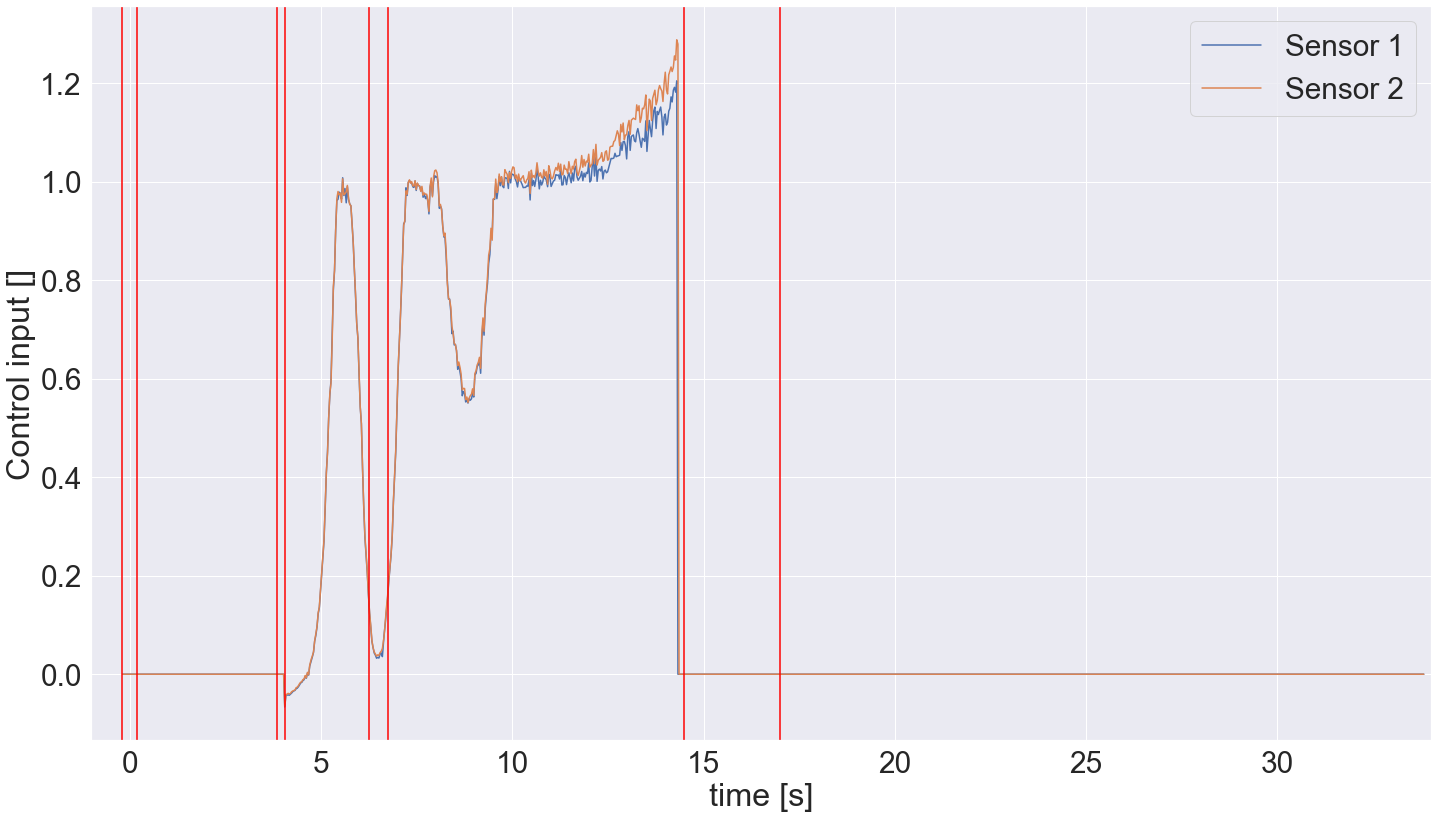

In [26]:
# Control plots

def compute_speed_of_sound(h) -> float:
    C = np.sqrt(gamma * R_const * Temp(h))
    return C

def compute_control_input(acc, vel, alt, t, method='theoretical'):
    if method == 'theoretical':
        n = len(acc)
        control_input = np.zeros(n)
        m_rocket_engineless = 31.5    # kg
        A_ref_rocket = m.pi * (0.179/2)**2

        control_activation_mach_number = 0.55
        control_deactivation_mach_number = 0.1

        for i in range(n):
            speed_of_sound = compute_speed_of_sound(alt[i])
            mach_number = vel[i] / speed_of_sound
            if (control_deactivation_mach_number < mach_number < control_activation_mach_number) and acc[i] > 0 and t_cruise < t[i] < 18:
                rho = compute_density(alt[i])
                control_input[i] = ((acc[i]) * 2 * m_rocket_engineless / (rho * A_ref_rocket * vel[i]**2) - Cd_ro1)/(Cd_tot1 - Cd_ro1)

    else:
        raise Exception('Control input method not defined')

    return control_input

import math as m
# First assumption: cd values known

control_input1 = compute_control_input(acc=np.array(combined['Ay_IMU1'][cond_launch]), vel=V_abs1, alt=X_array1[: ,2], t=t_array)
control_input2 = compute_control_input(acc=np.array(combined['Ay_IMU2'][cond_launch]), vel=V_abs2, alt=X_array2[: ,2], t=t_array)

t=combined["Time [s]"]
tab1,tab2,tab3,tab4,tab5,tab6,tab7, tab8 = -0.2, 0.2, t_burnout, t_cruise, 6.25,6.75,14.5, 17

cond_no_ab = ((t>tab1)&(t<tab2)) | ((t>tab3)&(t<tab4)) | ((t>tab5)&(t<tab6)) | ((t>tab7)&(t<tab8))
cond_no_ab_cut = cond_no_ab[t>-0.2]

plt.plot(t_array, control_input1, label="Sensor 1")
plt.plot(t_array, control_input2, label="Sensor 2")
plt.xlabel('time [s]')
plt.ylabel('Control input []')
plt.xlim(-1, duration)
plt.legend()
for t in  [tab1,tab2,tab3,tab4,tab5,tab6,tab7,tab8]:
    plt.axvline(t, color="red")


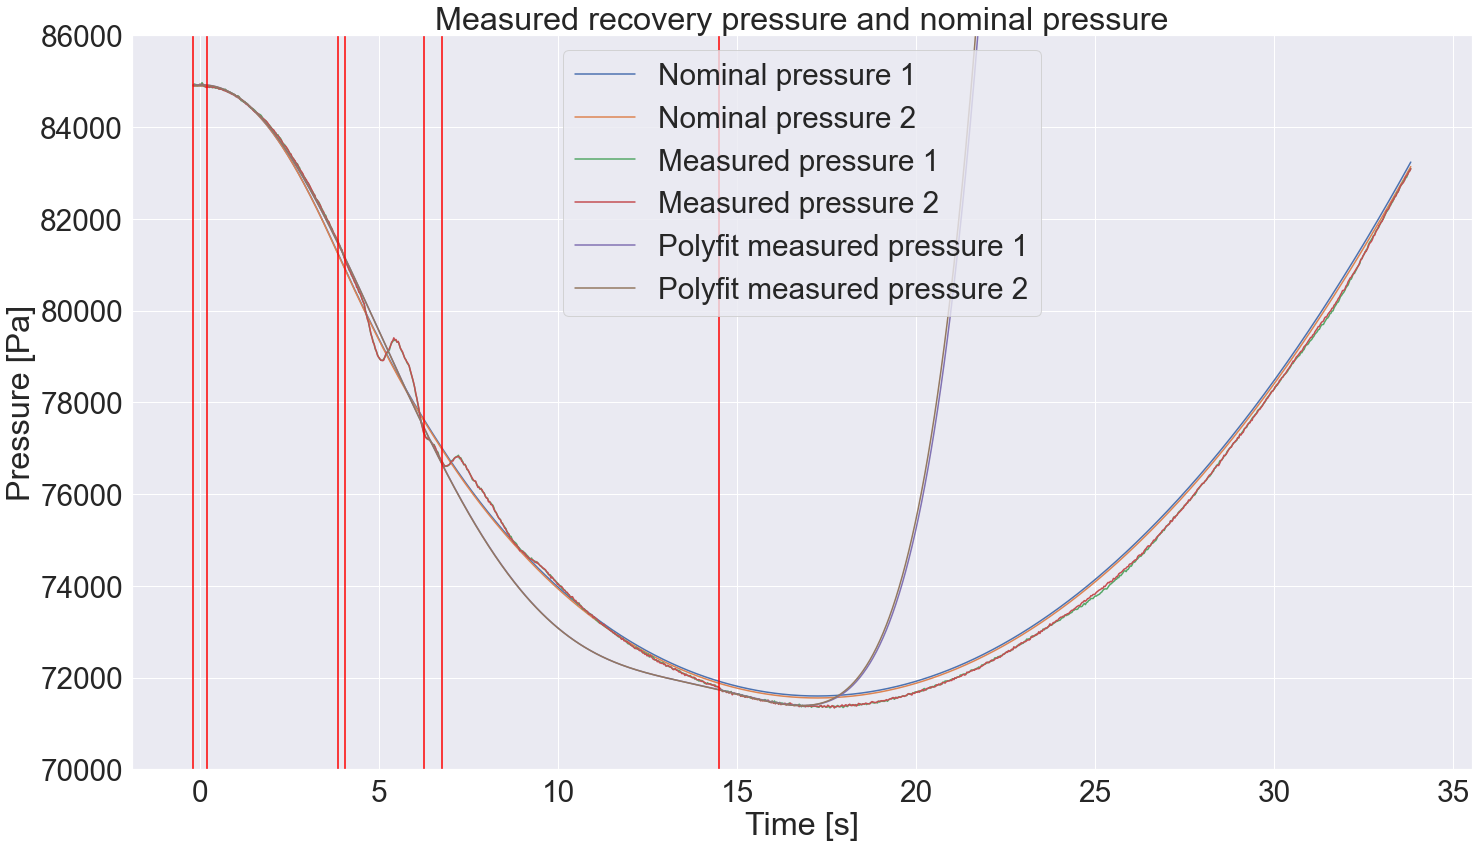

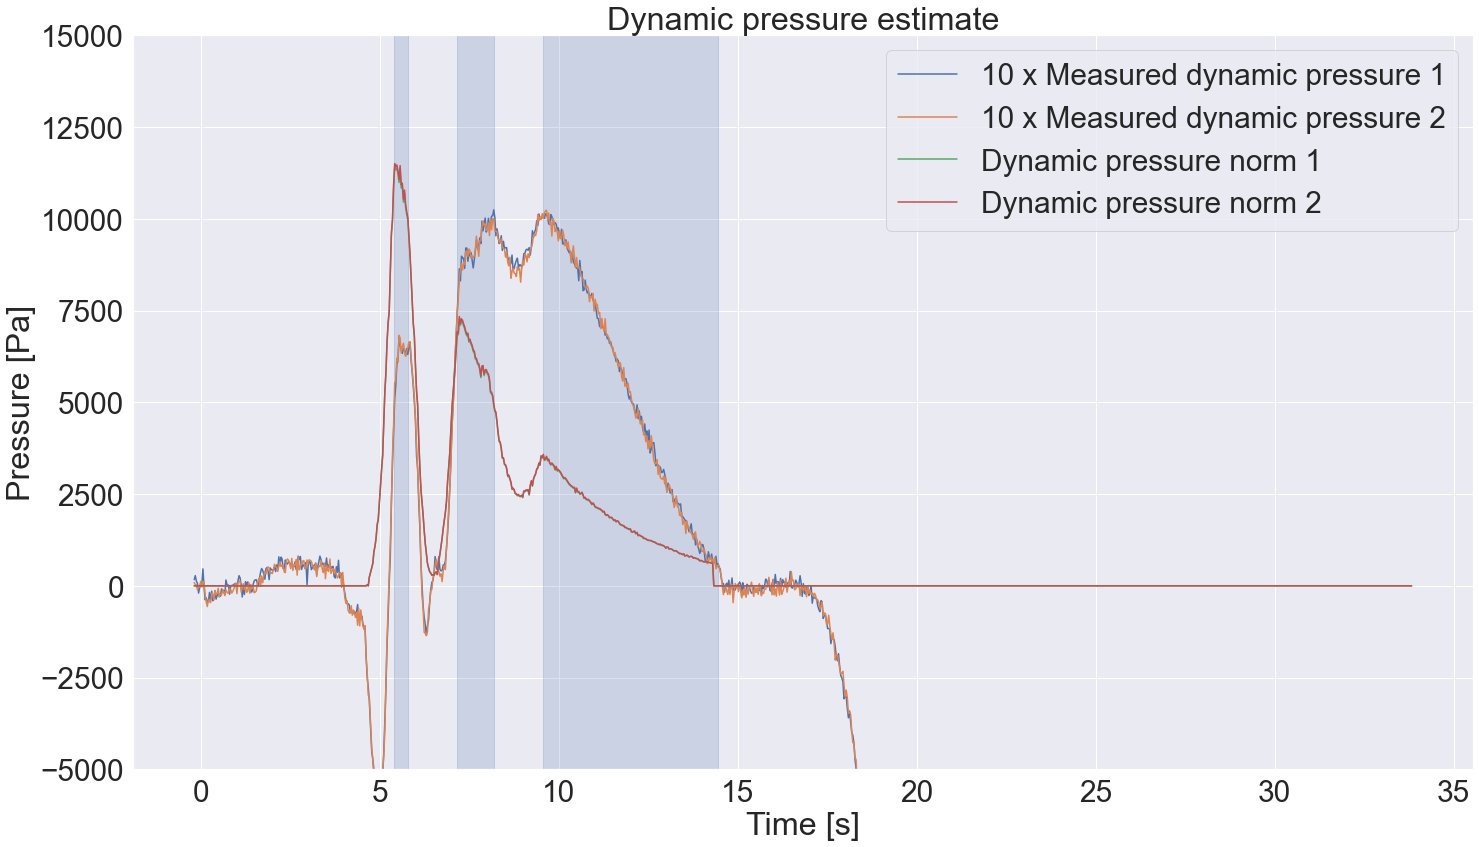

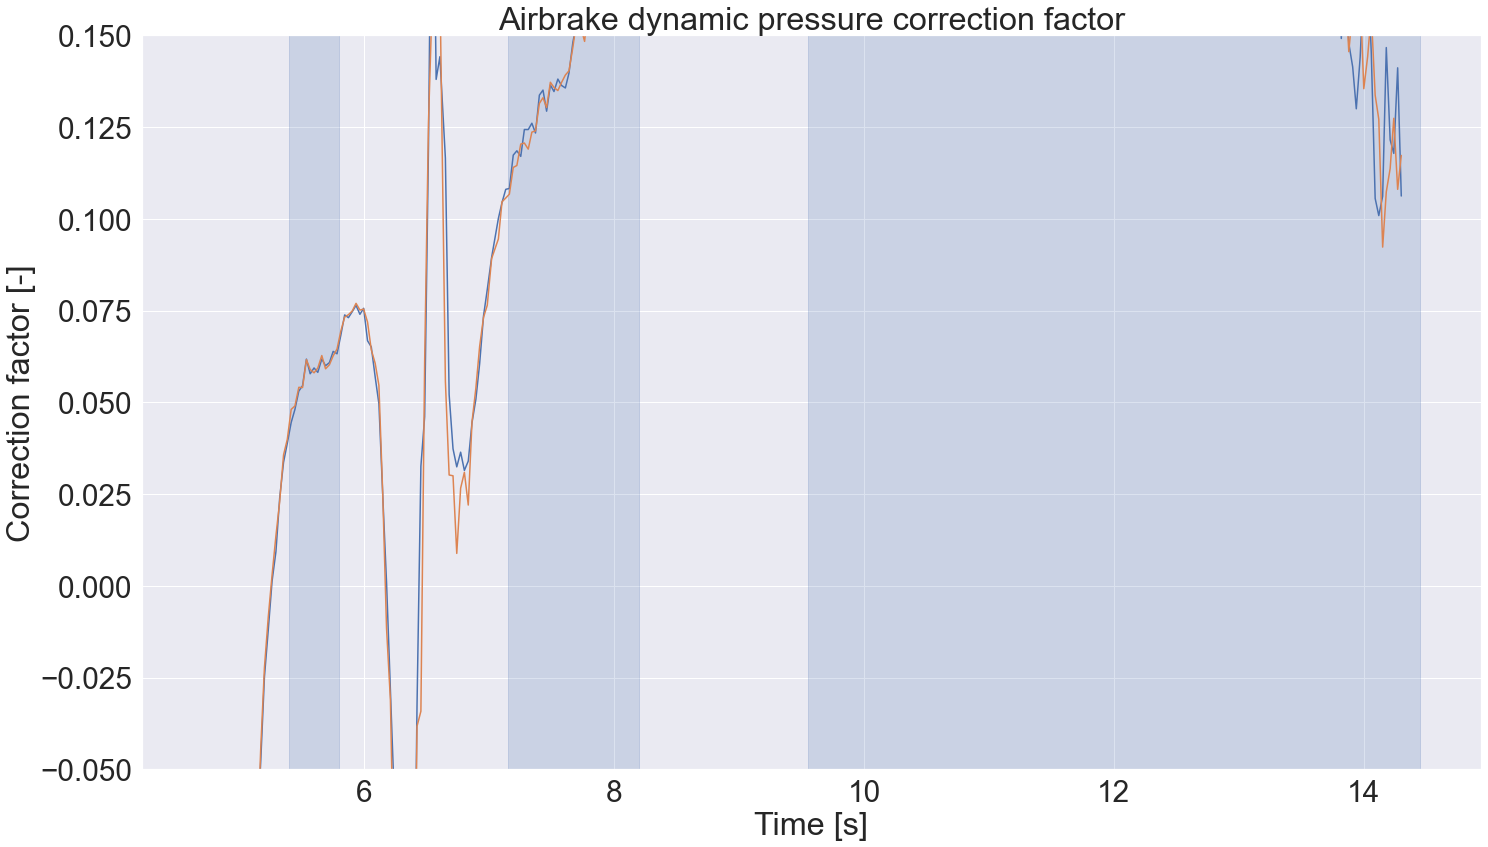

Aibrake dynamic pressure correction factor 1: mean=0.1900233820468293, stdev=0.20868764018697364
Aibrake dynamic pressure correction factor 2: mean=0.18691935563142462, stdev=0.2057195155355185


In [30]:
def Pressure(h) -> float:
    # input: h = altitude above ground level
    # output: Pressure = pressure
    Pressure = Pressure_g * (Temp(h) / Temp_g) ** ((-g) / (R_const * Temp_grad))
    return Pressure


# analysis of dynamic pressure on barometer measurements
altitude1 = X_array1[:, 2]
altitude2 = X_array2[:, 2]
nominal_pressure1 = Pressure(altitude1)
nominal_pressure2 = Pressure(altitude2)
measured_pressure1 = combined.reset_index()['Pressure 1 [kPa]'][cond_launch]*1000
measured_pressure2 = combined.reset_index()['Pressure 2 [kPa]'][cond_launch]*1000


poly_coeffs1 = np.polyfit(combined["Time [s]"][cond_launch&cond_no_ab]-t_apogee, measured_pressure1[cond_no_ab], 6)
poly_coeffs2 = np.polyfit(combined["Time [s]"][cond_launch&cond_no_ab]-t_apogee, measured_pressure2[cond_no_ab], 6)

polyfit_measured_pressure1 = np.poly1d(poly_coeffs1)
polyfit_measured_pressure2 = np.poly1d(poly_coeffs2)

measured_dynamic_pressure1 = measured_pressure1 - polyfit_measured_pressure1(combined["Time [s]"][cond_launch]-t_apogee)
measured_dynamic_pressure2 = measured_pressure2 - polyfit_measured_pressure1(combined["Time [s]"][cond_launch]-t_apogee)

airbrake_extension1 = control_input1
airbrake_extension1[control_input1 < 0] = 0
airbrake_extension2 = control_input1
airbrake_extension2[control_input2 < 0] = 0

dynamic_pressure_norm1 = airbrake_extension1 * rho1 * V_abs1**2 / 2
dynamic_pressure_norm2 = airbrake_extension2 * rho2 * V_abs2**2 / 2

plt.plot(combined["Time [s]"][cond_launch], nominal_pressure1)
plt.plot(combined["Time [s]"][cond_launch], nominal_pressure2)
plt.plot(combined["Time [s]"][cond_launch], measured_pressure1)
plt.plot(combined["Time [s]"][cond_launch], measured_pressure2)
plt.plot(combined["Time [s]"][cond_launch], polyfit_measured_pressure1(combined["Time [s]"][cond_launch]-t_apogee))
plt.plot(combined["Time [s]"][cond_launch], polyfit_measured_pressure2(combined["Time [s]"][cond_launch]-t_apogee))
plt.title("Measured recovery pressure and nominal pressure")
plt.legend(["Nominal pressure 1", "Nominal pressure 2", "Measured pressure 1", "Measured pressure 2", 
            "Polyfit measured pressure 1", "Polyfit measured pressure 2"])
plt.xlabel("Time [s]")
plt.ylabel("Pressure [Pa]")
for t in  [tab1,tab2,tab3,tab4,tab5,tab6,tab7]:
    plt.axvline(t, color="red")
plt.ylim(7e4,8.6e4)

plt.show()

plt.plot(combined["Time [s]"][cond_launch], 10*measured_dynamic_pressure1)
plt.plot(combined["Time [s]"][cond_launch], 10*measured_dynamic_pressure2)
plt.plot(combined["Time [s]"][cond_launch], dynamic_pressure_norm1)
plt.plot(combined["Time [s]"][cond_launch], dynamic_pressure_norm2)
plt.title("Dynamic pressure estimate")
plt.legend(["10 x Measured dynamic pressure 1", "10 x Measured dynamic pressure 2", 
            "Dynamic pressure norm 1", "Dynamic pressure norm 2"])
plt.xlabel("Time [s]")
plt.ylabel("Pressure [Pa]")
show_flight_events=False
plot_events(plt)
show_flight_events=True
plt.ylim(-5e3,15e3)

plt.show()

# airbrake dynamic pressure correction factor in recovery section
corr_factor_cond1 = airbrake_extension1 > 0
corr_factor_cond2 = airbrake_extension2 > 0
t_ab_corr_factor1 = combined["Time [s]"][cond_launch][corr_factor_cond1]
t_ab_corr_factor2 = combined["Time [s]"][cond_launch][corr_factor_cond2]
ab_dp_corr_factor1 = measured_dynamic_pressure1[corr_factor_cond1] / dynamic_pressure_norm1[corr_factor_cond1]
ab_dp_corr_factor2 = measured_dynamic_pressure2[corr_factor_cond2] / dynamic_pressure_norm2[corr_factor_cond2]

# we need to take aways some weird first shock peak
t_min_ab_dp_cut = 4.7
t_ab_corr_factor1_cut = t_ab_corr_factor1[t_ab_corr_factor1 > t_min_ab_dp_cut]
t_ab_corr_factor2_cut = t_ab_corr_factor2[t_ab_corr_factor2 > t_min_ab_dp_cut]
ab_dp_corr_factor1_cut = ab_dp_corr_factor1[t_ab_corr_factor1 > t_min_ab_dp_cut]
ab_dp_corr_factor2_cut = ab_dp_corr_factor2[t_ab_corr_factor2 > t_min_ab_dp_cut]

plt.plot(t_ab_corr_factor1_cut, ab_dp_corr_factor1_cut)
plt.plot(t_ab_corr_factor2_cut, ab_dp_corr_factor2_cut)
plt.title("Airbrake dynamic pressure correction factor")
plt.xlabel("Time [s]")
plt.ylabel("Correction factor [-]")
plt.ylim(-0.05,0.15)
show_flight_events=False
plot_events(plt)
show_flight_events=True
plt.show()

ab_dp_corr_factor1_mean, ab_dp_corr_factor1_stdev = np.mean(ab_dp_corr_factor1_cut), np.std(ab_dp_corr_factor1_cut)
ab_dp_corr_factor2_mean, ab_dp_corr_factor2_stdev = np.mean(ab_dp_corr_factor2_cut), np.std(ab_dp_corr_factor2_cut)
print(f"Aibrake dynamic pressure correction factor 1: mean={ab_dp_corr_factor1_mean}, stdev={ab_dp_corr_factor1_stdev}")
print(f"Aibrake dynamic pressure correction factor 2: mean={ab_dp_corr_factor2_mean}, stdev={ab_dp_corr_factor2_stdev}")

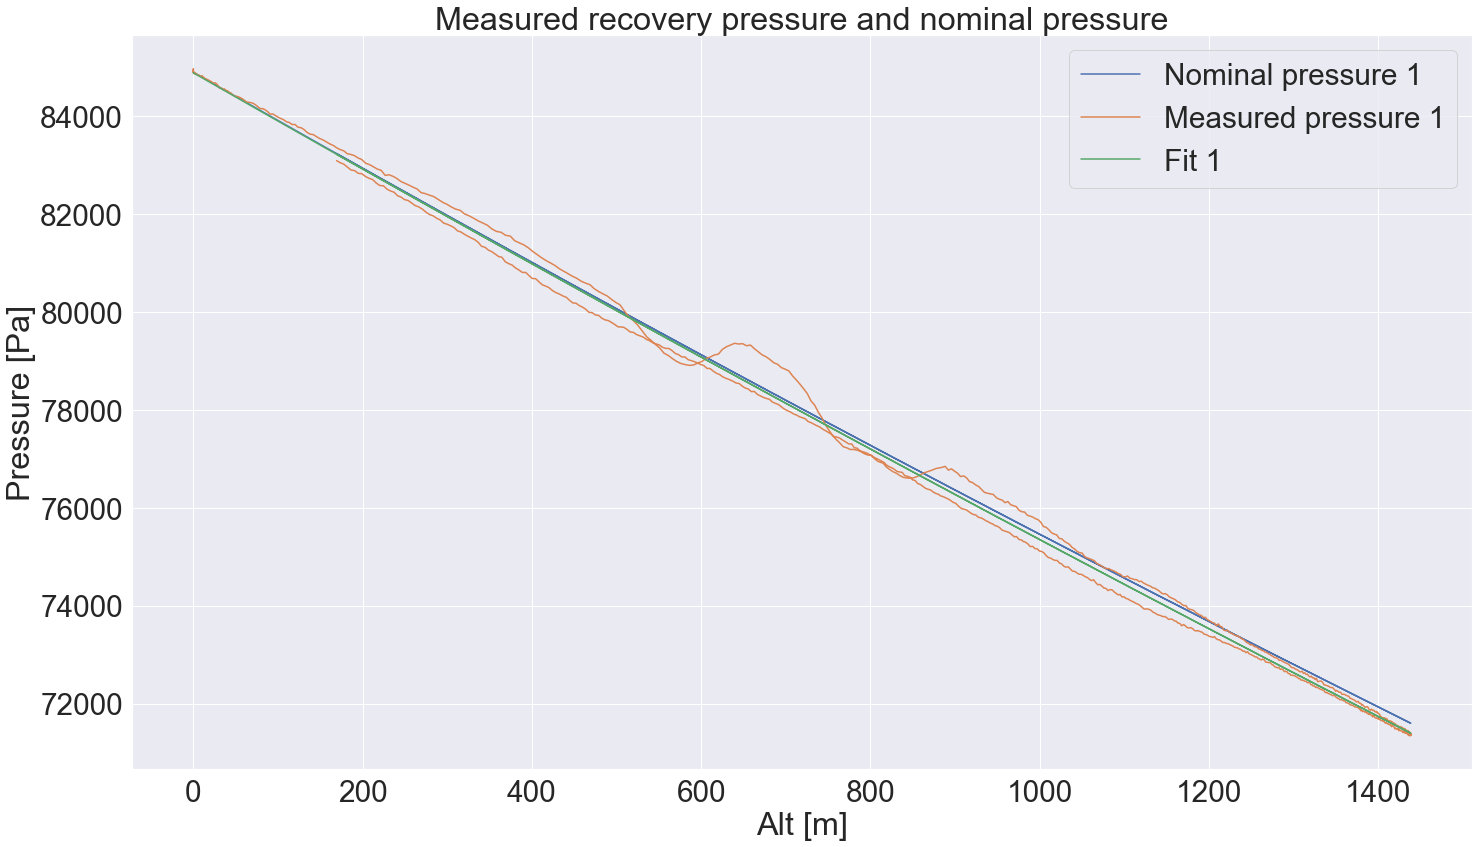

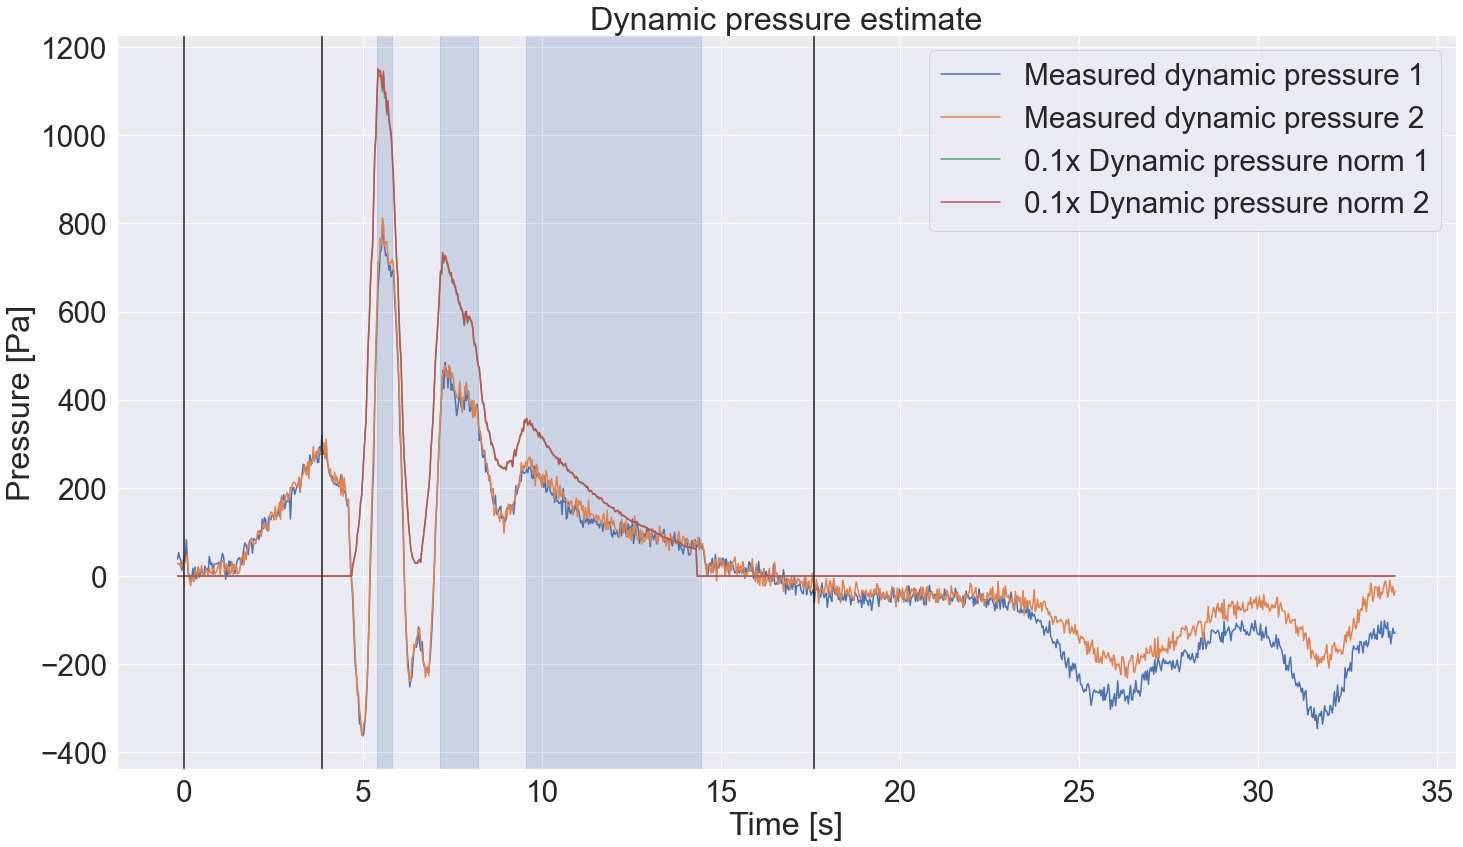

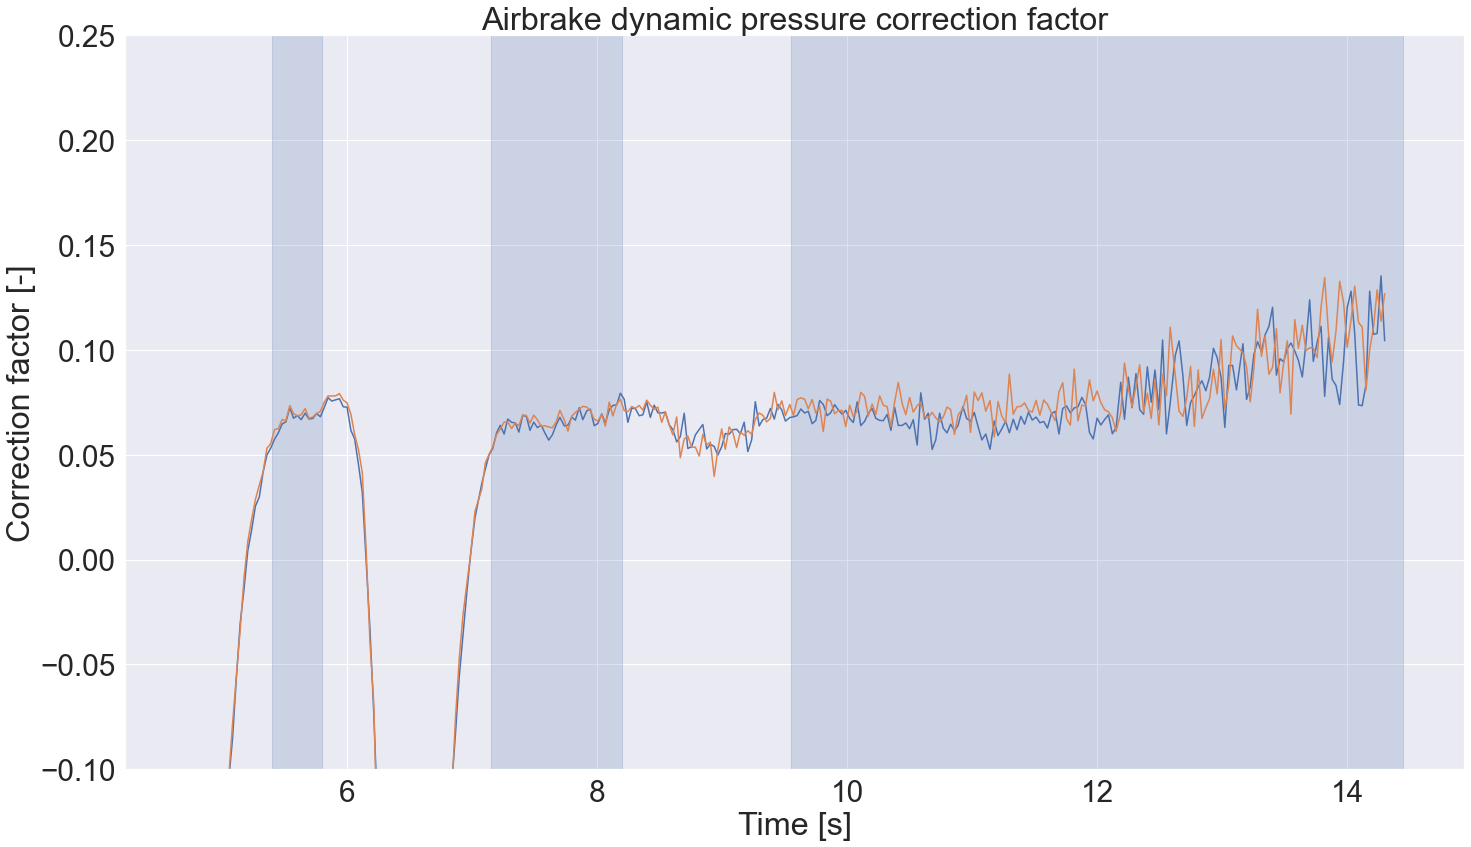

Aibrake dynamic pressure correction factor 1: mean=0.030082851768308463, stdev=0.12108653653700271
Aibrake dynamic pressure correction factor 2: mean=0.034726414767290416, stdev=0.11486964600470168


In [32]:
plt.plot(X_array1[:,2], nominal_pressure1, label="Nominal pressure 1")
#plt.plot(X_array2[:,2], nominal_pressure2, label="Nominal pressure 2")
plt.plot(X_array1[:,2], measured_pressure1, label="Measured pressure 1")
#plt.plot(X_array2[:,2], measured_pressure2, label="Measured pressure 2")

cond_descent = (combined["Time [s]"][cond_launch] <2) | (combined["Time [s]"][cond_launch] > 14.5)


def Pressure_fit(h, Pressure_g, Temp_grad) -> float:
    # input: h = altitude above ground level
    # output: Pressure = pressure
    Temp_g = 293
    Pressure = Pressure_g * ((Temp_g - h * Temp_grad) / Temp_g) ** ((-g) / (R_const * Temp_grad))
    
    return Pressure

popt1, pcov1= sp.optimize.curve_fit(Pressure_fit,  X_array1[:,2][cond_no_ab_cut],  measured_pressure1[cond_no_ab_cut],
                                    p0 = [85000,  0.065])
popt2, pcov2= sp.optimize.curve_fit(Pressure_fit,  X_array2[:,2][cond_no_ab_cut],  measured_pressure2[cond_no_ab_cut],
                                    p0 = [85000,  0.065])

fit_p_h1 = Pressure_fit(X_array1[:,2], *popt1)
fit_p_h2 = Pressure_fit(X_array2[:,2], *popt2)

plt.plot(X_array1[:,2], fit_p_h1, label="Fit 1")
#plt.plot(X_array2[:,2], fit_p_h2, label="Fit 2")

plt.title("Measured recovery pressure and nominal pressure")
plt.legend()
plt.xlabel("Alt [m]")
plt.ylabel("Pressure [Pa]")
plt.show()

measured_dynamic_pressure1 = measured_pressure1 - fit_p_h1
measured_dynamic_pressure2 = measured_pressure2 - fit_p_h2

airbrake_extension1 = control_input1
airbrake_extension1[control_input1 < 0] = 0
airbrake_extension2 = control_input1
airbrake_extension2[control_input2 < 0] = 0

dynamic_pressure_norm1 = airbrake_extension1 * rho1 * V_abs1**2 / 2
dynamic_pressure_norm2 = airbrake_extension2 * rho2 * V_abs2**2 / 2


plt.plot(combined["Time [s]"][cond_launch], measured_dynamic_pressure1)
plt.plot(combined["Time [s]"][cond_launch], measured_dynamic_pressure2)
plt.plot(combined["Time [s]"][cond_launch], 0.1*dynamic_pressure_norm1)
plt.plot(combined["Time [s]"][cond_launch], 0.1*dynamic_pressure_norm2)
plt.title("Dynamic pressure estimate")
plt.legend(["Measured dynamic pressure 1", "Measured dynamic pressure 2", 
            "0.1x Dynamic pressure norm 1", "0.1x Dynamic pressure norm 2"])
plt.xlabel("Time [s]")
plt.ylabel("Pressure [Pa]")
#show_flight_events=False
plot_events(plt)
#show_flight_events=True
plt.show()

# airbrake dynamic pressure correction factor in recovery section
corr_factor_cond1 = airbrake_extension1 > 0
corr_factor_cond2 = airbrake_extension2 > 0
t_ab_corr_factor1 = combined["Time [s]"][cond_launch][corr_factor_cond1]
t_ab_corr_factor2 = combined["Time [s]"][cond_launch][corr_factor_cond2]
ab_dp_corr_factor1 = measured_dynamic_pressure1[corr_factor_cond1] / dynamic_pressure_norm1[corr_factor_cond1]
ab_dp_corr_factor2 = measured_dynamic_pressure2[corr_factor_cond2] / dynamic_pressure_norm2[corr_factor_cond2]

# we need to take aways some weird first shock peak
t_min_ab_dp_cut = 4.7
t_ab_corr_factor1_cut = t_ab_corr_factor1[t_ab_corr_factor1 > t_min_ab_dp_cut]
t_ab_corr_factor2_cut = t_ab_corr_factor2[t_ab_corr_factor2 > t_min_ab_dp_cut]
ab_dp_corr_factor1_cut = ab_dp_corr_factor1[t_ab_corr_factor1 > t_min_ab_dp_cut]
ab_dp_corr_factor2_cut = ab_dp_corr_factor2[t_ab_corr_factor2 > t_min_ab_dp_cut]

plt.plot(t_ab_corr_factor1_cut, ab_dp_corr_factor1_cut)
plt.plot(t_ab_corr_factor2_cut, ab_dp_corr_factor2_cut)
plt.title("Airbrake dynamic pressure correction factor")
plt.xlabel("Time [s]")
plt.ylabel("Correction factor [-]")
plt.ylim(-0.1,0.25)
show_flight_events=False
plot_events(plt)
show_flight_events=True
plt.show()

ab_dp_corr_factor1_mean, ab_dp_corr_factor1_stdev = np.mean(ab_dp_corr_factor1_cut), np.std(ab_dp_corr_factor1_cut)
ab_dp_corr_factor2_mean, ab_dp_corr_factor2_stdev = np.mean(ab_dp_corr_factor2_cut), np.std(ab_dp_corr_factor2_cut)
print(f"Aibrake dynamic pressure correction factor 1: mean={ab_dp_corr_factor1_mean}, stdev={ab_dp_corr_factor1_stdev}")
print(f"Aibrake dynamic pressure correction factor 2: mean={ab_dp_corr_factor2_mean}, stdev={ab_dp_corr_factor2_stdev}")

In [ ]:
'''
import image
import imageio
from mayavi import mlab
from tvtk.api import tvtk

mlab.options.offscreen = False
%gui qt

#read map tiff
#im1 = imageio.imread("animation_input/swissimage1m_latest_wide.tif")
#im1=np.rot90(im1,k=4)

#write map png
#imageio.imwrite("animation_input/swissimage1m_latest_wide.jpg", im1[:,:,:3])
'''


In [ ]:
'''
#read alt profile
im=imageio.imread('animation_input/dhm25_dhm25_wide.tif')
im=np.rot90(im,k=3)

vert_factor = 20
X_plot = derot_array(X_array1, 221, LR_angle=0)
x, y, z = X_plot.T / 25# transpose and unpack 
v_abs1 = np.sqrt(V_array1[:,0]**2+V_array1[:,1]**2+V_array1[:,2]**2)

x0= 2025/25 - 69.5
y0= 2011/25 - 69.5
z0= 1565/vert_factor
'''

In [ ]:
# trajectory plotting test
'''
# trajectory plotting test
bmp1 = tvtk.JPEGReader()
bmp1.file_name="animation_input/swissimage1m_latest_wide_marking.jpg" #any jpeg file

texture = tvtk.Texture(input_connection=bmp1.output_port, interpolate=0)

f=mlab.figure(size=(1500, 1000), bgcolor=(0., 0.3, 0.6))

surf = mlab.surf(im, color=(1,1,1),warp_scale=1./vert_factor) 
surf.actor.enable_texture = True
surf.actor.tcoord_generator_mode = 'plane'
surf.actor.actor.texture = texture
#mlab.axes()

line=mlab.plot3d(x+x0, y+y0, z+z0, v_abs1, tube_radius=0.2)
mlab.view(135, 60)
mlab.view(distance=130)
mlab.view(distance=z.max()*2.2,
          focalpoint=((x.mean()+x0),
                      (y.mean()+y0),
                      (z.max()/1.9+z0)))

mlab.show()
mlab.savefig('example.png')
'''

In [ ]:
# animation
'''
# animation
import os

bmp1 = tvtk.JPEGReader()
bmp1.file_name="animation_input/swissimage1m_latest_wide.jpg" #any jpeg file

texture = tvtk.Texture(input_connection=bmp1.output_port, interpolate=0)

f=mlab.figure(size=(1200, 1200), bgcolor=(0., 0.25, 0.5))

surf = mlab.surf(im, color=(1,1,1),warp_scale=1./vert_factor) 
surf.actor.enable_texture = True
surf.actor.tcoord_generator_mode = 'plane'
surf.actor.actor.texture = texture

line=mlab.plot3d(x[0]+x0, y[0]+y0, z[0]+z0, v_abs1[0], tube_radius=0.2, colormap="YlOrRd", vmax=v_abs1.max())

mlab.view(135, 65)
mlab.view(distance=130)

az_init=100
el_init=77
d_min = 40

mlab.view(az_init, el_init)
mlab.view(distance=d_min, focalpoint=(x0,y0,z0))

fig = mlab.gcf()
ms = line.mlab_source

step_size=2
n_steps = int(X_plot.shape[0]/step_size)
delay = int(35000/n_steps ) 

video_frames=[]

@mlab.animate(delay=10, ui=False)
def anim():
    for i in range(-int(0.0*n_steps), int(n_steps*1.2)):
        if (i >= 0) & (i < n_steps):
            xnew, ynew, znew = X_plot[:(i+1)*step_size].T / 25# transpose and unpack 
            vnew = v_abs1[:(i+1)*step_size]
            ms.reset(x=xnew+x0, y=ynew+y0, z=znew+z0, scalars=vnew)
            #if znew[-1] == znew.max():
            mlab.view(az_init+i/n_steps*60, el_init)
            mlab.view(distance=np.maximum(d_min,znew.max()*2.15),
                      focalpoint=((xnew.mean()+x0),
                                  (ynew.mean()+y0),
                                  (znew.max()/1.9+z0)))


        
        if (i < 0):
            mlab.view(az_init+i/n_steps*60, el_init)
            mlab.view(distance=d_min,
                      focalpoint=(x0,y0,z0))
            

            
        if (i > n_steps):
            mlab.view(az_init+i/n_steps*60, el_init)
            
            mlab.view(distance=np.maximum(d_min,znew.max()*2.15),
                      focalpoint=((xnew.mean()+x0),
                              (ynew.mean()+y0),
                              (znew.max()/1.9+z0)))
            

        video_frames.append(mlab.screenshot()[:,:,[2,1,0]])
        
        yield

a=anim()
'''

In [ ]:
# videoframes to movie
'''
import cv2

video_name = "ML_animation_hq3.mp4"
video_path = os.path.join("animation_output", video_name)
frame = video_frames[0]
height, width, layers = frame.shape
video = cv2.VideoWriter(video_path, 0, fps=int(1.5 * 1000/delay), frameSize=(width,height))

for image in video_frames:
    video.write(image)

cv2.destroyAllWindows()
video.release()
'''